<h1><center>Streaming Data Management and Time Series Analysis Project</h1></center>

<center><img src="pics/bicoc.png" style="width:250px;height:250px;"></center>

-------------

<center><img src="pics/dslogo.png" style="width:400px;height:100px;"></center>

### <div style="text-align: right"> Davide Brinati, Matricola: 771458 </div>

#### Le principali librerie implementate in questo progetto sono: 
<div style="text-align: center">Pandas</div>
<img src="pics/pandas.jpg" style="width:100px;height:100px;">

<div style="text-align: center">Numpy</div>
<img src="pics/Num.png" style="width:100px;height:50px;">

<div style="text-align: center">Matplotlib</div>
<img src="pics/mpltl.png" style="width:150px;height:50px;">

<div style="text-align: center">Statsmodels</div>
<img src="pics/statsmodels.png" style="width:100px;height:100px;">

<div style="text-align: center">Pytorch</div>
<img src="pics/pytorch-logo.png" style="width:100px;height:100px;">

Il dataset utilizzato per questo studio è __[Appliance Energy Prediction Dataset](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)__ (from UCI Repository). La time series che verrà presa in considerazione è quella relativa alla variabile *lights*, che rappresenta i consumi elettrici per l'illuminazione.

Si utilizzeranno i seguenti modelli:
* [Arima](#section1)
* [Unobserved Component Models](#section2)
* [Recurrent Neural Networks](#section3)

Per l'implementazione con Pytorch è necessario posizionare i seguenti file nella stessa directory di questo notebook:
* __models.py__ Il file contiene i codici delle RNN
* __ts_loader.py__ Questo file contiene un oggetto dataloader
* __utils.py__ Funzioni per facilitire il caricamento dei dati

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('fivethirtyeight') 
from pylab import rcParams
from plotly import tools
import math
import copy
import regex as re
import time
import datetime
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#PYTORCH IMPORT
from models import *
from utils import *
from ts_loader import Time_Series_Data

%matplotlib inline

Using TensorFlow backend.


### 1st view on data

In [2]:
data = pd.read_csv('energydata_complete.csv')
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


### Data manipulation

#### Si estrae l'info su giorno e ora con una regex

hour:

In [4]:
x = '2016-01-11 17:10:00'

prova = re.compile(r'^[^_]* (.*)$')
a=re.sub(prova, r"\1", x)
print(a)

17:10:00


day:

In [5]:
prova2 = re.compile(r'^(.*) [^_]*$')
a=re.sub(prova2, r"\1", x)
print(a)

2016-01-11


#### Applico sul dataframe

In [6]:
data['day'] = ''
data['time'] = ''

regex_day = re.compile(r'^(.*) [^_]*$')
regex_time = re.compile(r'^[^_]* (.*)$')

for i in range(data.shape[0]):
    day = re.sub(regex_day, r"\1", data['date'][i])
    time = re.sub(regex_time, r"\1", data['date'][i])
    data['day'][i] = day
    data['time'][i] = time
    if i % 1000 == 0 and i != 0:
        print('Processed {} rows'.format(i))

Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows


In [7]:
data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'time'],
      dtype='object')

In [8]:
data = data[['date', 'day', 'time', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
               'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
               'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
               'Visibility', 'Tdewpoint', 'rv1', 'rv2']]

In [9]:
data.head(12)

,date,day,time,Appliances,lights,T1,RH_1,T2,RH_2,T3,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,2016-01-11,17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.79,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,2016-01-11,17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.79,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,2016-01-11,17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.79,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,2016-01-11,17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.79,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,2016-01-11,17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.79,...,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,2016-01-11,17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.79,...,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,2016-01-11,18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.79,...,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,2016-01-11,18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.73,...,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,2016-01-11,18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.73,...,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,2016-01-11,18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.79,...,17.000000,45.29,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


In [10]:
data.tail()

,date,day,time,Appliances,lights,T1,RH_1,T2,RH_2,T3,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,2016-05-27,17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,2016-05-27,17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,2016-05-27,17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,2016-05-27,17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,2016-05-27,18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [11]:
data.shape

(19735, 31)

-------------------------

#### Si unisce l'informazione riguardo al giorno e all'ora in un'unica feature, per le successive groupby

Provo regex

In [12]:
regex = re.compile(r'^(.*):[^_]*:[^_]*$')
x = '17:40:00'
a = re.sub(regex, r"\1", x)
a

'17'

-----------------------

In [13]:
regex = re.compile(r'^(.*):[^_]*:[^_]*$')
data['new_feat'] = ''

for i in range(data.shape[0]):
    temp = ''
    h = re.sub(regex, r"\1", data['time'][i])
    temp = data['day'][i] + ' ' + h
    data['new_feat'][i] = temp
    if i % 1000 == 0 and i != 0:
        print('Processed {} rows'.format(i))

Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows


In [14]:
#Riordino le colonne
data = data [['date', 'day', 'time', 'new_feat', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
               'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
               'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
               'Visibility', 'Tdewpoint', 'rv1', 'rv2']]

In [15]:
data.head(10)

,date,day,time,new_feat,Appliances,lights,T1,RH_1,T2,RH_2,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,2016-01-11,17:00:00,2016-01-11 17,60,30,19.890000,47.596667,19.20,44.790000,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,2016-01-11,17:10:00,2016-01-11 17,60,30,19.890000,46.693333,19.20,44.722500,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,2016-01-11,17:20:00,2016-01-11 17,50,30,19.890000,46.300000,19.20,44.626667,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,2016-01-11,17:30:00,2016-01-11 17,50,40,19.890000,46.066667,19.20,44.590000,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,2016-01-11,17:40:00,2016-01-11 17,60,40,19.890000,46.333333,19.20,44.530000,...,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,2016-01-11,17:50:00,2016-01-11 17,50,40,19.890000,46.026667,19.20,44.500000,...,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,2016-01-11,18:00:00,2016-01-11 18,60,50,19.890000,45.766667,19.20,44.500000,...,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,2016-01-11,18:10:00,2016-01-11 18,60,50,19.856667,45.560000,19.20,44.500000,...,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,2016-01-11,18:20:00,2016-01-11 18,60,40,19.790000,45.597500,19.20,44.433333,...,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,2016-01-11,18:30:00,2016-01-11 18,70,40,19.856667,46.090000,19.23,44.400000,...,17.000000,45.29,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


#### La variabile "new_feat" riporta l'informazione sul giorno e sull'ora in cui è stata effettuata la rilevazione

In [16]:
data.shape

(19735, 32)

In [17]:
data.to_csv('temp.csv')     #Salvo un csv e riprenderò da qua

In [18]:
data = pd.read_csv('temp.csv', index_col=0)        #Riprendo e carico il csv

-----------------------

In [19]:
tcol = ['date', 'day', 'time']
timecolumns = data[tcol]
data.drop(tcol, axis =1, inplace=True)

In [20]:
data.shape

(19735, 29)

#### Si controlla che ogni ora abbia 6 osservazioni, in caso affermativo si aggrega tramite somma, altrimenti con la media.

In [21]:
data.groupby('new_feat').count()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
new_feat,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 18,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 19,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 20,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 21,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 22,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-11 23,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-12 00,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2016-01-12 01,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [22]:
prova = data.groupby('new_feat').count()[:-1] #Rimuovo l'ultima riga, dato che c'è solo solo un'ora di osserv.

In [23]:
count= 0
for i in prova.values:
    for j in i:
        if int(j) != 6:
            count+=1
        
print('DataFrame contains {} values unequal to 6!'.format(count))

DataFrame contains 0 values unequal to 6!


### Aggregazione con somma

In [24]:
df = data.groupby('new_feat', as_index=False).sum()

In [25]:
df.head(10)

,new_feat,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17,330,210,119.340000,279.016667,115.200000,267.759167,118.740000,269.386667,113.596667,...,102.100000,272.680000,37.85,4402.50,552.0,37.0,320.5,30.30,160.938267,160.938267
1,2016-01-11 18,1060,310,119.386667,275.274167,115.613333,266.633333,118.620000,269.180000,113.450000,...,101.890000,271.740000,35.65,4405.60,549.5,32.5,240.0,27.95,133.945235,133.945235
2,2016-01-11 19,1040,150,122.973333,316.833333,119.553333,276.370000,120.313333,283.364167,113.816667,...,101.413333,271.868333,36.00,4408.75,538.5,36.0,240.0,26.35,202.409592,202.409592
3,2016-01-11 20,750,210,125.766667,290.720000,121.506667,273.795833,121.283333,283.613333,115.145000,...,101.340000,270.713333,36.00,4411.70,525.5,36.0,240.0,24.10,154.077851,154.077851
4,2016-01-11 21,620,140,127.870000,274.610000,123.526667,269.766667,122.240000,276.986667,116.553333,...,101.340000,268.846667,35.00,4413.40,524.5,36.0,240.0,22.90,112.957645,112.957645
5,2016-01-11 22,1600,130,129.433333,267.980000,125.433333,264.713333,122.816667,274.976667,120.653333,...,101.140000,267.165833,34.35,4416.05,525.5,38.5,240.0,22.45,162.862245,162.862245
6,2016-01-11 23,340,110,129.190000,265.626667,125.606667,262.275000,121.907500,274.175000,125.458333,...,101.340000,271.446667,33.90,4419.30,534.5,39.5,195.0,23.55,175.258768,175.258768
7,2016-01-12 00,850,100,127.596667,269.763333,123.823333,264.110000,120.866667,273.253333,123.086667,...,101.340000,275.250000,31.30,4422.90,552.0,36.0,177.0,24.10,157.780308,157.780308
8,2016-01-12 01,1010,50,125.781667,273.679167,122.000000,265.640000,120.800000,273.240000,129.033333,...,101.340000,277.846667,30.85,4427.00,552.0,33.5,240.0,23.65,172.338439,172.338439
9,2016-01-12 02,270,0,124.180000,277.186667,120.400000,267.020000,121.025000,272.725000,126.858333,...,101.853333,283.580000,30.20,4431.30,552.0,27.5,240.0,23.00,103.694322,103.694322


In [26]:
df.tail(3)

,new_feat,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
3287,2016-05-27 16,810,0,152.926667,277.5,156.000000,250.417143,167.720000,243.646667,148.2,...,139.16,279.872286,137.3,4532.25,330.0,14.5,135.5,79.7,139.376066,139.376066
3288,2016-05-27 17,1080,20,153.200000,280.7,154.633143,254.972857,162.986667,247.486667,148.2,...,139.20,280.683929,136.0,4531.20,335.0,20.5,144.5,79.9,163.116016,163.116016
3289,2016-05-27 18,430,10,25.500000,46.6,25.264286,42.971429,26.823333,41.156667,24.7,...,23.20,46.845000,22.2,755.20,57.0,4.0,27.0,13.2,34.118851,34.118851


In [27]:
df.shape

(3290, 29)

### "lights" sarà  $y_{t}$


In [28]:
dfts = df[['new_feat', 'lights']]
dfts.head(3)

,new_feat,lights
0,2016-01-11 17,210
1,2016-01-11 18,310
2,2016-01-11 19,150


In [29]:
dfts['new_feat'] = pd.to_datetime(dfts['new_feat'])
dfts.head()

,new_feat,lights
0,2016-01-11 17:00:00,210
1,2016-01-11 18:00:00,310
2,2016-01-11 19:00:00,150
3,2016-01-11 20:00:00,210
4,2016-01-11 21:00:00,140


### Plot

#### Linechart

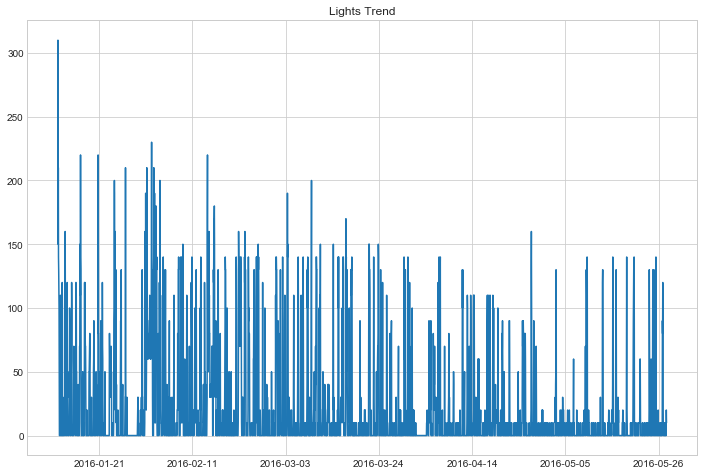

In [30]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
plt.plot(dfts['new_feat'], dfts['lights'])
plt.title('Lights Trend')
plt.show()

In [31]:
#All ts
dfts['lights'].describe()

count    3290.000000
mean       22.805471
std        41.399233
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       310.000000
Name: lights, dtype: float64

In [32]:
#First ts half
dfts['lights'][:1500].describe()

count    1500.000000
mean       32.326667
std        48.787705
min         0.000000
25%         0.000000
50%        10.000000
75%        50.000000
max       310.000000
Name: lights, dtype: float64

In [33]:
#Second half (more or less)
dfts['lights'][1500:].describe()

count    1790.000000
mean       14.826816
std        31.887662
min         0.000000
25%         0.000000
50%         0.000000
75%        10.000000
max       170.000000
Name: lights, dtype: float64

##### Different mean and std between first and second half suggest non-stationarity

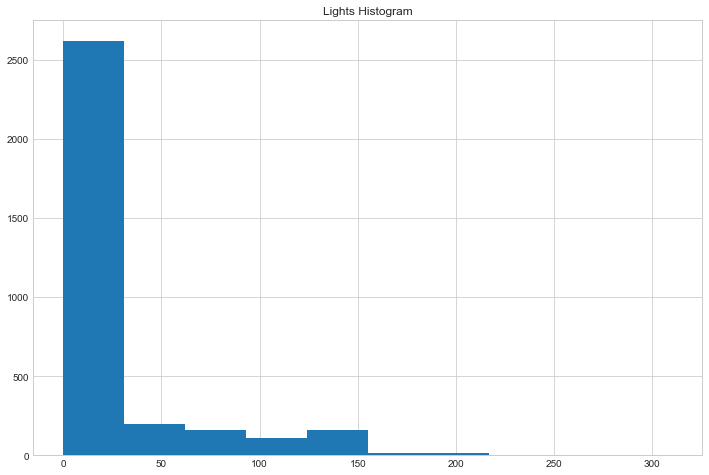

In [34]:
plt.figure(figsize=(12,8))
plt.hist(dfts['lights'])
plt.title('Lights Histogram')
plt.show()

## Comparison lights vs appliances

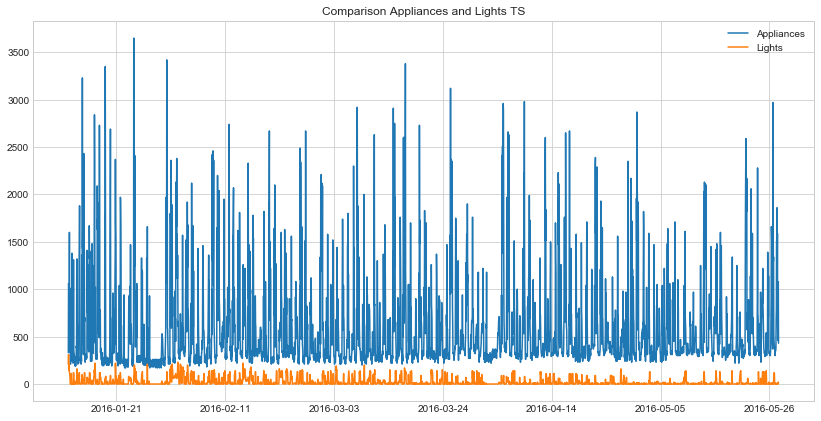

In [35]:
plt.figure(figsize=(14,7))
plt.plot(dfts['new_feat'], df['Appliances'])
plt.plot(dfts['new_feat'], df['lights'])
plt.legend(['Appliances', 'Lights'])
plt.title('Comparison Appliances and Lights TS')
plt.show()

## Time series decomposition and Random Walks

Lights

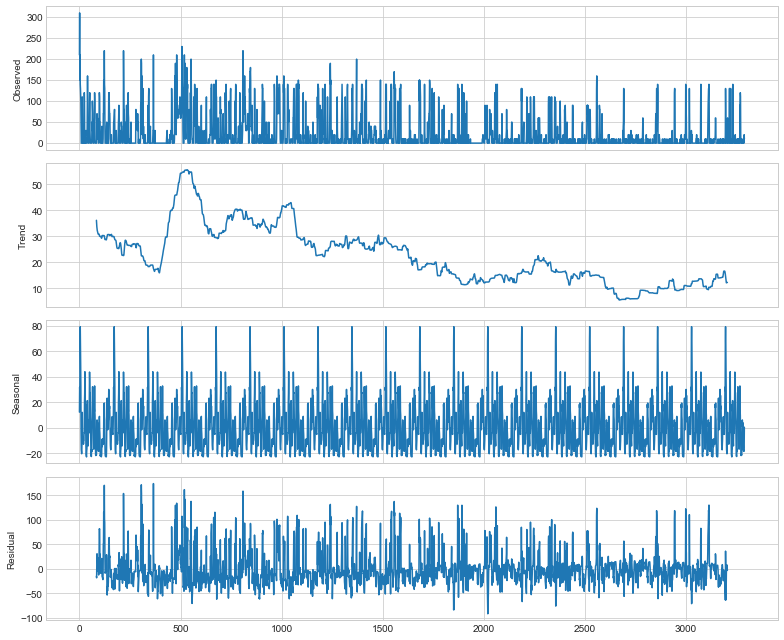

In [36]:
# Now, seasonal decomposition
rcParams['figure.figsize'] = 11, 9
decomposed_lights = sm.tsa.seasonal_decompose(dfts['lights'],freq=168) #24x7=168 -->trend of the week
figure = decomposed_lights.plot()
plt.show()

<a id='section1'></a>

## Linear models: ARIMA-SARIMA

#### Il primo passo è la correzione della non stazionarietà in varianza. Si controlla la relazione tra standard deviation e media su finistre temporali giornaliere. Se la relazione è di tipo lineare la miglior trasformazione è quella logaritmica.

In [37]:
temp = data[['new_feat','lights']]
temp.head(10)

,new_feat,lights
0,2016-01-11 17,30
1,2016-01-11 17,30
2,2016-01-11 17,30
3,2016-01-11 17,40
4,2016-01-11 17,40
5,2016-01-11 17,40
6,2016-01-11 18,50
7,2016-01-11 18,50
8,2016-01-11 18,40
9,2016-01-11 18,40


In [38]:
h_mu = temp.groupby('new_feat').mean()
h_std = temp.groupby('new_feat').std()

In [39]:
h_mu.head()

,lights
new_feat,
2016-01-11 17,35.000000
2016-01-11 18,51.666667
2016-01-11 19,25.000000
2016-01-11 20,35.000000
2016-01-11 21,23.333333


In [40]:
h_std.head()

,lights
new_feat,
2016-01-11 17,5.477226
2016-01-11 18,11.690452
2016-01-11 19,17.606817
2016-01-11 20,8.366600
2016-01-11 21,5.163978


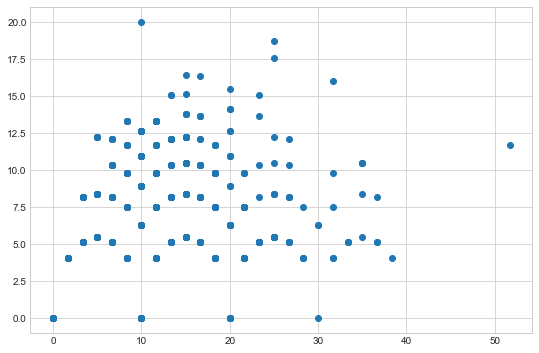

In [41]:
plt.figure(figsize=(9,6))
plt.scatter(h_mu['lights'], h_std['lights'])

#### Applico una trasformazione logaritmica. Prima pongo i valori pari a 0 uguali a 1, dato che il log(0) non è definito

In [42]:
y = dfts.copy()
y = y.replace({0:1})
y.head(20)

,new_feat,lights
0,2016-01-11 17:00:00,210
1,2016-01-11 18:00:00,310
2,2016-01-11 19:00:00,150
3,2016-01-11 20:00:00,210
4,2016-01-11 21:00:00,140
5,2016-01-11 22:00:00,130
6,2016-01-11 23:00:00,110
7,2016-01-12 00:00:00,100
8,2016-01-12 01:00:00,50
9,2016-01-12 02:00:00,1


In [43]:
y.tail()

,new_feat,lights
3285,2016-05-27 14:00:00,10
3286,2016-05-27 15:00:00,1
3287,2016-05-27 16:00:00,1
3288,2016-05-27 17:00:00,20
3289,2016-05-27 18:00:00,10


#### Training and test sets

In [44]:
y[:2647].tail()

,new_feat,lights
2642,2016-04-30 19:00:00,10
2643,2016-04-30 20:00:00,1
2644,2016-04-30 21:00:00,1
2645,2016-04-30 22:00:00,10
2646,2016-04-30 23:00:00,1


In [45]:
y[2647:].head()

,new_feat,lights
2647,2016-05-01 00:00:00,1
2648,2016-05-01 01:00:00,1
2649,2016-05-01 02:00:00,1
2650,2016-05-01 03:00:00,1
2651,2016-05-01 04:00:00,1


- Training ----> From January to April. 
- Test ---------> May

In [46]:
training = y[:2647]
test = y[2647:]

In [47]:
print(training.shape, test.shape)

(2647, 2) (643, 2)


Apply log transformation

In [53]:
y_train = np.log(training['lights'])
y_test = np.log(test['lights'])

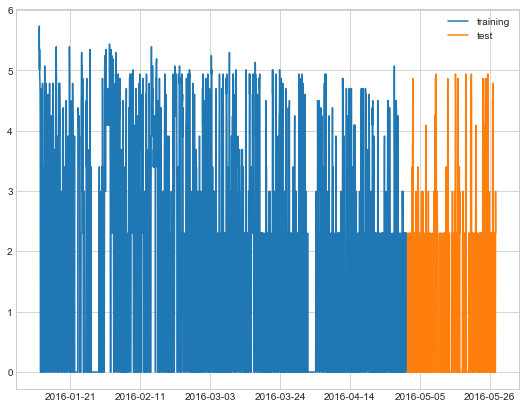

In [54]:
plt.figure(figsize=(9,7))
plt.plot(dfts['new_feat'][:2647],y_train, label='training')
plt.plot(dfts['new_feat'][2647:],y_test, label= 'test')
plt.legend()
plt.show()

#### La non stazionarietà in varianza sembra risolta.

#### Ora applico una differenza stagionale, in questa caso giornaliera, ovvero di 24 periodi ---> ES: il consumo energetico di luce richiesta oggi alle ore 20, probabilmente non sarà troppo diverso da quello di ieri, alla stessa ora

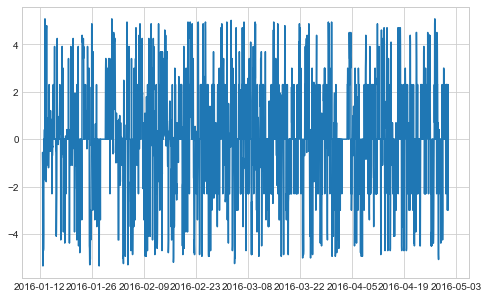

In [55]:
d24y_train = y_train.diff(periods=24)

plt.figure(figsize=(8,5))
plt.plot(dfts['new_feat'][24:2647],d24y_train[24:])

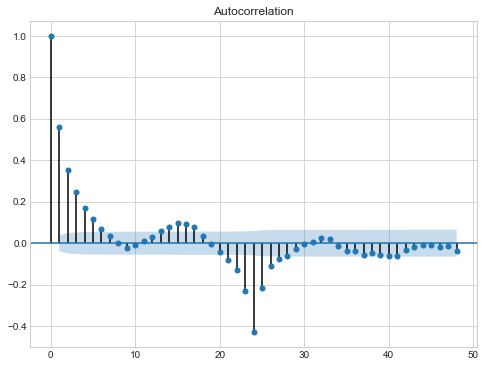

In [56]:
rcParams['figure.figsize'] = 8, 6
plot_acf(d24y_train[24:],lags=48)
plt.show()

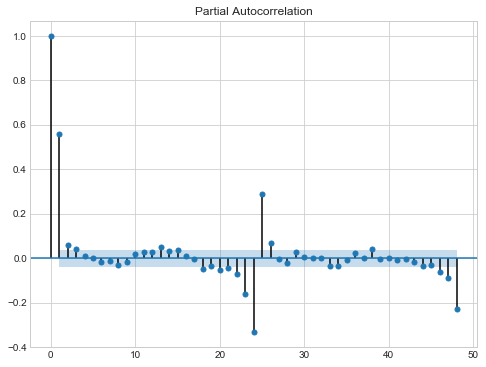

In [57]:
plot_pacf(d24y_train[24:],lags=48)
plt.show()

### I grafici ACF e PACF mostrano una stagionalità in corrispondenza del ritardo 24, inoltre il grafico ACF mostra un decadimento geometrico dell'autocorrelazione; il PACF ha il primo ed il secondo ritardo oltre le bande di confidenza ---> pertanto di opterà per un processo AR(2) stagionale

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 24)   Log Likelihood               -4882.183
Date:                            Fri, 13 Sep 2019   AIC                           9772.367
Time:                                    16:28:37   BIC                           9795.815
Sample:                                         0   HQIC                          9780.863
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5279      0.018     28.929      0.000       0.492       0.564
ar.L2          0.0866      0.019   

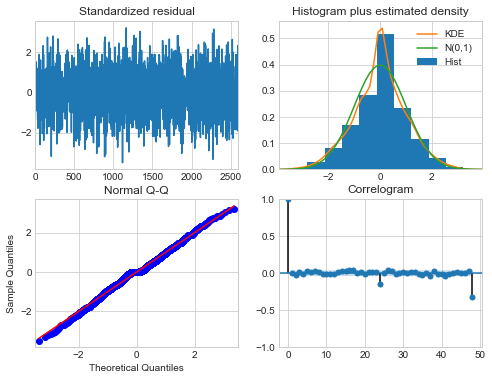

In [58]:
model = SARIMAX(y_train, order = (2,0,0),seasonal_order=(1,1,0,24),enforce_stationarity=False)
model_fit = model.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model_fit.summary())
model_fit.plot_diagnostics(lags=48)
plt.show()

### Piccola parentesi sui metodi .forecast() e .predict()

In [59]:
# con il metodo forecast() il modello predice in avanti di tot step
model_fit.forecast(5)

2647    0.199405
2648    0.105270
2649    0.072842
2650    0.047571
2651    0.031422
dtype: float64

In [60]:
#con predict() parte la realzzazione del processo stocastico da start ad end
model_fit.predict(start=0,end=10)

0     0.000000
1     1.411416
2     2.238885
3     2.322868
4     2.444403
5     2.371888
6     2.319123
7     2.251082
8     2.197191
9     1.972322
10    0.727538
dtype: float64

------------------

## Focus su ACF e PACF dei residui del modello

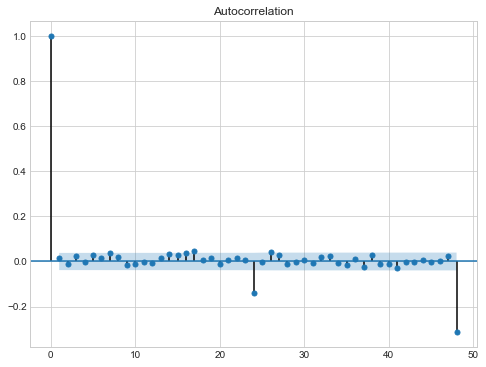

In [61]:
plot_acf(model_fit.resid,lags=48)
plt.show()

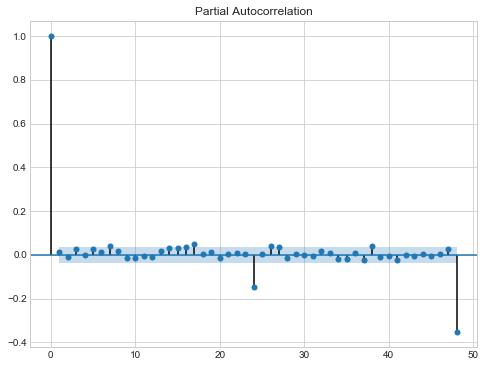

In [62]:
plot_pacf(model_fit.resid,lags=48)
plt.show()

## Inserisco nel modello una parte MA stagionale, dato che sia acf che pacf mostrano un correlazione oltre le bande ogni 24 periodi

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(2, 0, 0)x(1, 1, 1, 24)   Log Likelihood               -4457.320
Date:                            Fri, 13 Sep 2019   AIC                           8924.639
Time:                                    16:29:19   BIC                           8953.950
Sample:                                         0   HQIC                          8935.260
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5420      0.019     28.931      0.000       0.505       0.579
ar.L2          0.0938      0.018   

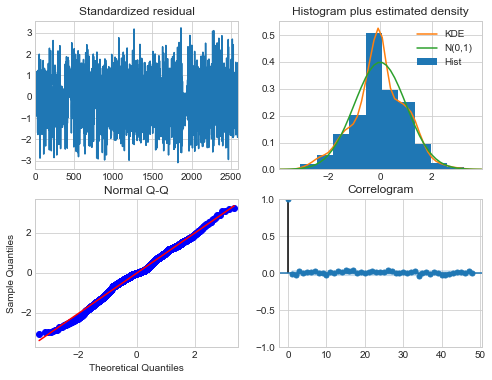

In [63]:
model2 = SARIMAX(y_train, order = (2,0,0),seasonal_order=(1,1,1,24),enforce_stationarity=False)
model2_fit = model2.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model2_fit.summary())
model2_fit.plot_diagnostics(lags=48)
plt.show()

## ACF e PACF dei residui

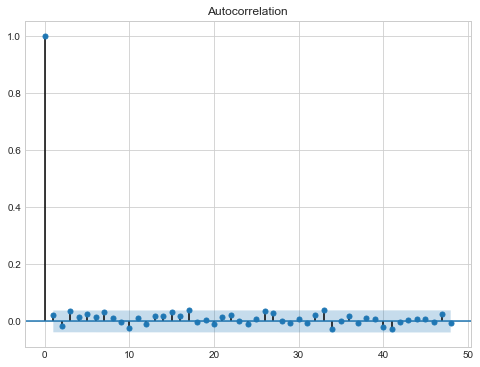

In [64]:
plot_acf(model2_fit.resid,lags=48)
plt.show()

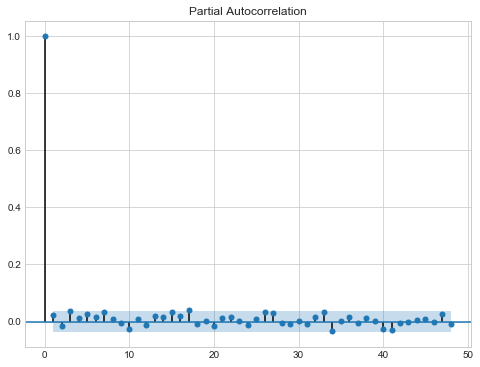

In [65]:
plot_pacf(model2_fit.resid,lags=48)
plt.show()

## I correlogrammi mostrano che i residui hanno un comportamento White  Noise: il modello proposto sfrutta tutta la memoria lineare

### Prediction on test

In [66]:
# con il metodo forecast() il modello predice in avanti di tot step
pred = model2_fit.forecast(643)

In [67]:
print(mean_absolute_error(y_test, pred))

1.2164100952067483


In [68]:
print(mean_squared_error(y_test, pred))

2.066261045220299


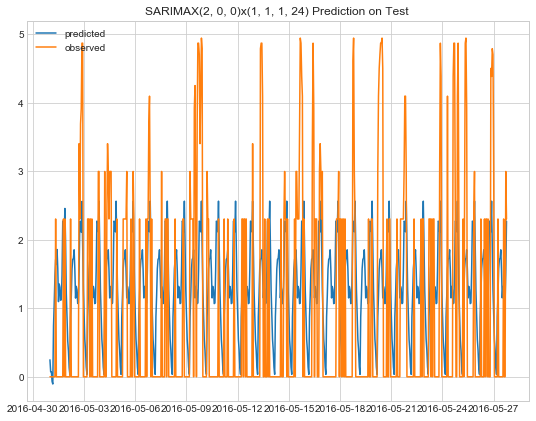

In [69]:
plt.figure(figsize=(9,7))
plt.plot(dfts['new_feat'][2647:],pred, label='predicted')
plt.plot(dfts['new_feat'][2647:],y_test, label= 'observed')
plt.legend()
plt.title('SARIMAX(2, 0, 0)x(1, 1, 1, 24) Prediction on Test ')
plt.show()

#### MSE on non-logarithmic

In [72]:
pred_nolog = np.exp(pred)
print(mean_squared_error(test['lights'], pred_nolog))

774.3221166060772


### Benchmark: my predictor vs mean

In [76]:
len(y_test)

643

In [77]:
y_test.shape

(643,)

In [78]:
mean_predictor = y_train.mean()
mean_predictor = np.full((643),mean_predictor)
mean_squared_error(y_test, mean_predictor)

2.7716783322683343

In [79]:
mse_sarima = mean_squared_error(y_test, pred)
mse_baseline = mean_squared_error(y_test, mean_predictor)
print('MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

MSE Sarima Model / MSE Baseline: 0.7454909255394281


#### Benchmark non log

In [82]:
mean = training['lights'].mean()
mean = np.full((643),mean)
mean_squared_error(test['lights'], mean)

986.9216028923194

In [84]:
mse_sarima = mean_squared_error(test['lights'], pred_nolog)
mse_baseline = mean_squared_error(test['lights'], mean)
print('NON LOG VALUES --> MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

NON LOG VALUES --> MSE Sarima Model / MSE Baseline: 0.7845832073558954


----------------------------------------

# Ora provo a differenziare una serie già differenziata stagionalmente e si riparte con la scelta e formulazione del modello!!

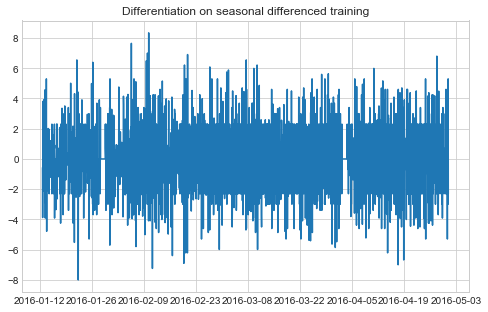

In [85]:
#DIFFERENZIATO ++ DIFF STAGIONALE
dd24y_train = y_train.diff(periods=24).diff()

plt.figure(figsize=(8,5))
plt.plot(dfts['new_feat'][25:2647],dd24y_train[25:])
plt.title('Differentiation on seasonal differenced training')
plt.show()

### ACF & PACF

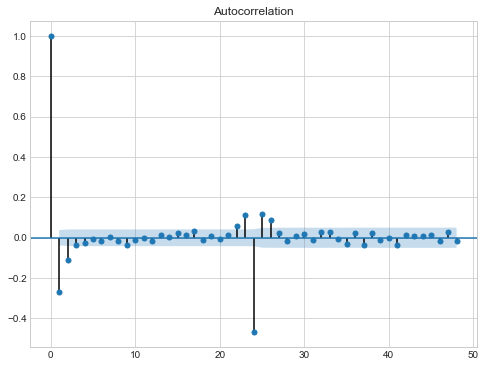

In [86]:
rcParams['figure.figsize'] = 8, 6
plot_acf(dd24y_train[25:],lags=48)
plt.show()

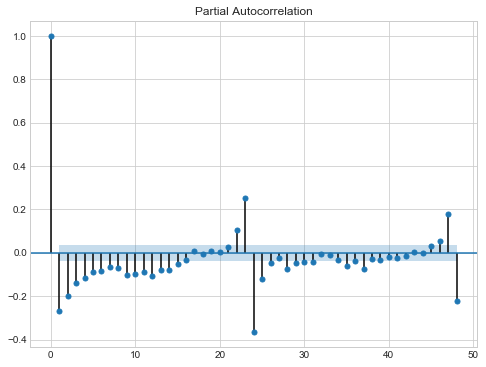

In [152]:
plot_pacf(dd24y_train[25:],lags=48)
plt.show()

## Il decadimento del PACF  è di tipo geometrico, mentre nell'ACF dopo il secondo ritardo, l'autocorrelazione rientra nelle bande di confidenza, pertanto utilizzerò un MA(2) stagionale, dato che ogni 24 periodi la correlazione esce dalle bande di conf.

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -4532.322
Date:                            Fri, 13 Sep 2019   AIC                           9072.644
Time:                                    16:45:59   BIC                           9096.089
Sample:                                         0   HQIC                          9081.140
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4497      0.018    -25.050      0.000      -0.485      -0.414
ma.L2         -0.2635      0.017   

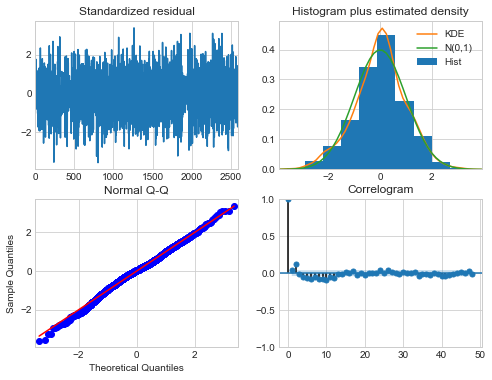

In [87]:
model3 = SARIMAX(y_train, order = (0,1,2),seasonal_order=(0,1,1,24),enforce_stationarity=False)
model3_fit = model3.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model3_fit.summary())
model3_fit.plot_diagnostics(lags=48)
plt.show()

### ACF & PACF sui residui

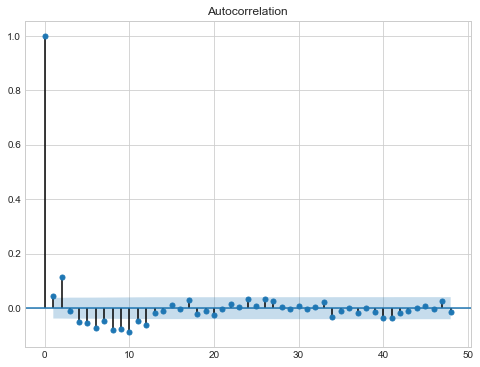

In [88]:
plot_acf(model3_fit.resid,lags=48)
plt.show()

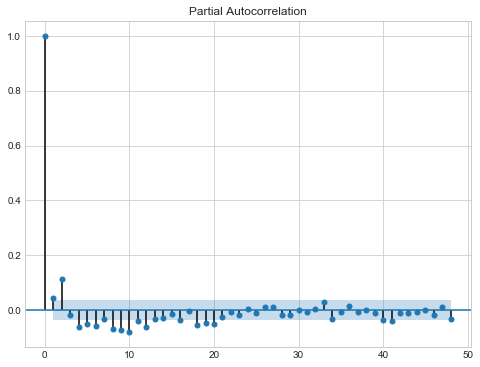

In [89]:
plot_pacf(model3_fit.resid,lags=48)
plt.show()

### Provo ad aggiungere una parte autoregressiva di ordine 1

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -4460.657
Date:                            Fri, 13 Sep 2019   AIC                           8931.315
Time:                                    16:46:49   BIC                           8960.622
Sample:                                         0   HQIC                          8941.935
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6988      0.024     29.390      0.000       0.652       0.745
ma.L1         -1.1633      0.031   

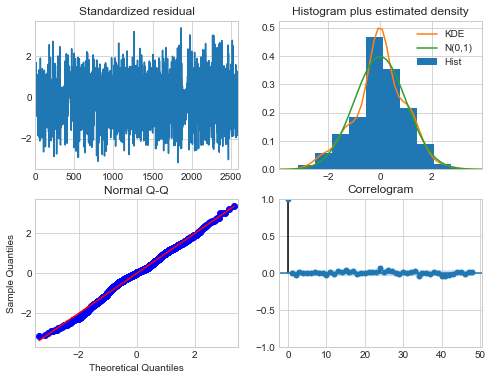

In [90]:
model3 = SARIMAX(y_train, order = (1,1,2),seasonal_order=(0,1,1,24),enforce_stationarity=False)
model3_fit = model3.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model3_fit.summary())
model3_fit.plot_diagnostics(lags=48)
plt.show()

#### ACF & PACF dei residui

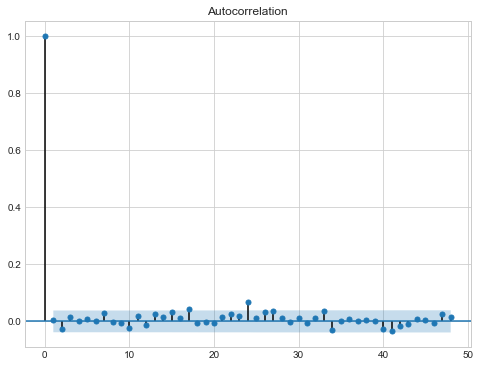

In [91]:
plot_acf(model3_fit.resid,lags=48)
plt.show()

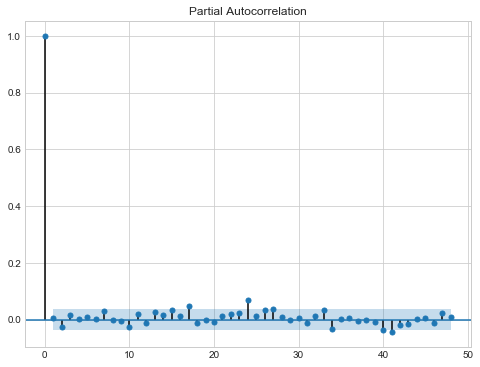

In [92]:
plot_pacf(model3_fit.resid,lags=48)
plt.show()

#### Al 24esimo ritardo sembra che ci sia una leggera correlazione oltre la banda di confidenza, pertanto aggiungo anche la parte AR stagionale

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 24)   Log Likelihood               -4459.126
Date:                            Fri, 13 Sep 2019   AIC                           8930.251
Time:                                    16:47:42   BIC                           8965.419
Sample:                                         0   HQIC                          8942.995
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6984      0.024     29.465      0.000       0.652       0.745
ma.L1         -1.1649      0.031   

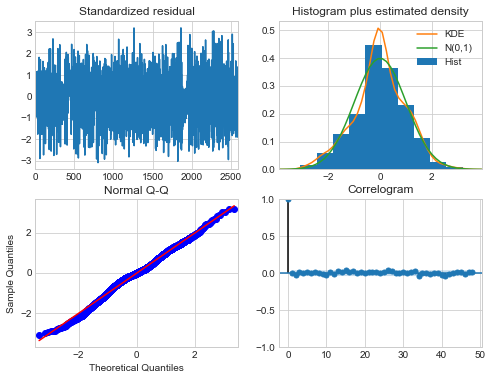

In [93]:
model3 = SARIMAX(y_train, order = (1,1,2),seasonal_order=(1,1,1,24),enforce_stationarity=False)
model3_fit = model3.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model3_fit.summary())
model3_fit.plot_diagnostics(lags=48)
plt.show()

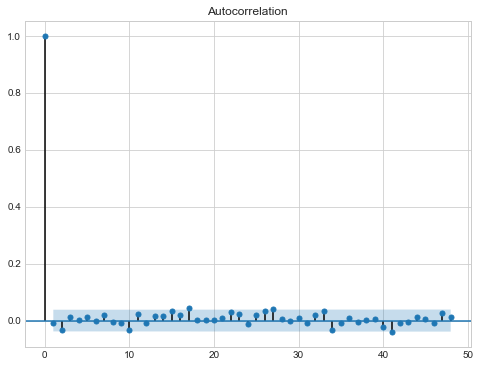

In [94]:
plot_acf(model3_fit.resid,lags=48)
plt.show()

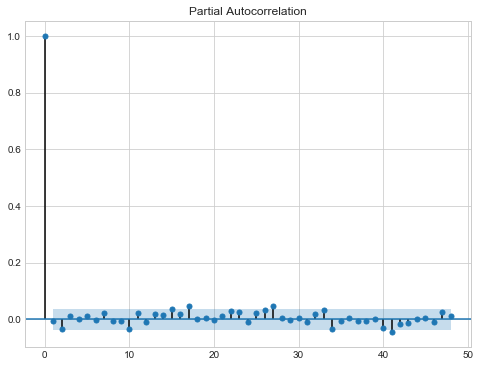

In [95]:
plot_pacf(model3_fit.resid,lags=48)
plt.show()

### I residui del modello stimato sembrano essere un White Noise ---> Ora forecasting sul test

In [96]:
pred2 = model3_fit.forecast(643)
print('MAE: {}\nMSE: {}'.format(mean_absolute_error(y_test, pred2), mean_squared_error(y_test, pred2)))

MAE: 1.1400310228146067
MSE: 2.068682541005165


In [103]:
pred2_nolog = np.exp(pred2)
print('MSE on non-log data: {}'.format(mean_squared_error(test['lights'], pred2_nolog)))

MSE on non-log data: 785.8510323617205


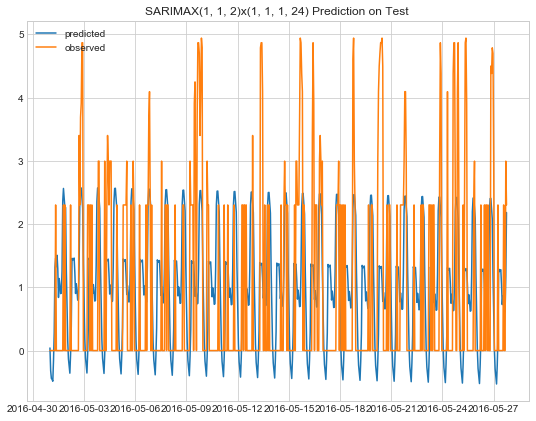

In [104]:
plt.figure(figsize=(9,7))
plt.plot(dfts['new_feat'][2647:],pred2, label='predicted')
plt.plot(dfts['new_feat'][2647:],y_test, label= 'observed')
plt.legend()
plt.title('SARIMAX(1, 1, 2)x(1, 1, 1, 24) Prediction on Test ')
plt.show()

Benchmark with baseline

In [105]:
mse_sarima = mean_squared_error(y_test, pred2)
mse_baseline = mean_squared_error(y_test, mean_predictor)
print('MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

MSE Sarima Model / MSE Baseline: 0.7463645823980449


Benchmark with non logarithmic

In [117]:
mse_sarima = mean_squared_error(test['lights'], pred2_nolog)
mse_baseline = mean_squared_error(test['lights'], mean)
print('NON LOG VALUES --> MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

NON LOG VALUES --> MSE Sarima Model / MSE Baseline: 0.7962649009391102


### statsmodel is an improving library, so it's time to try its arma_order_select_ic method, which searches best (p,q) parameters

In [186]:
resDiff = sm.tsa.arma_order_select_ic(y_train, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\done-\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\done-\Anaconda3\lib\site-pa

ARMA(p,q) = (7, 4) is the best.


                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(7, 1, 4)x(0, 1, 0, 24)   Log Likelihood               -5161.300
Date:                            Fri, 13 Sep 2019   AIC                          10346.600
Time:                                    16:53:25   BIC                          10417.028
Sample:                                         0   HQIC                         10372.110
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4557      0.018    -25.619      0.000      -0.491      -0.421
ar.L2         -0.4118      0.021   

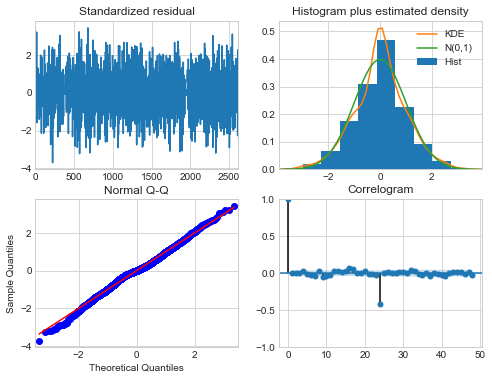

In [107]:
model4 = SARIMAX(y_train, order = (7,1,4),seasonal_order=(0,1,0,24),enforce_stationarity=False, 
                 enforce_invertibility=False,)
model4_fit = model4.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model4_fit.summary())
model4_fit.plot_diagnostics(lags=48)
plt.show()

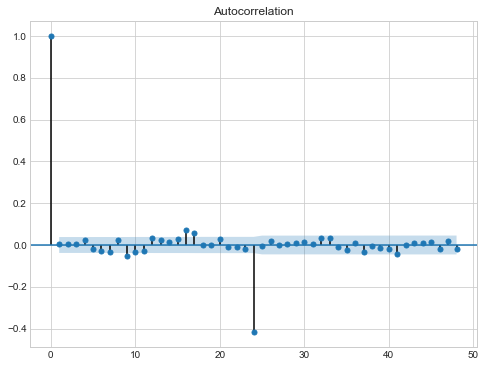

In [108]:
plot_acf(model4_fit.resid,lags=48)
plt.show()

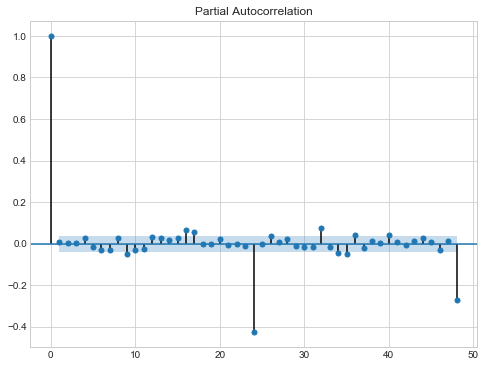

In [109]:
plot_pacf(model4_fit.resid,lags=48)
plt.show()

Introduco un MA stagionale

                                 Statespace Model Results                                 
Dep. Variable:                             lights   No. Observations:                 2647
Model:             SARIMAX(7, 1, 4)x(0, 1, 1, 24)   Log Likelihood               -4441.553
Date:                            Fri, 13 Sep 2019   AIC                           8909.106
Time:                                    16:55:25   BIC                           8985.293
Sample:                                         0   HQIC                          8936.714
                                           - 2647                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7369      0.086     -8.589      0.000      -0.905      -0.569
ar.L2         -0.4987      0.078   

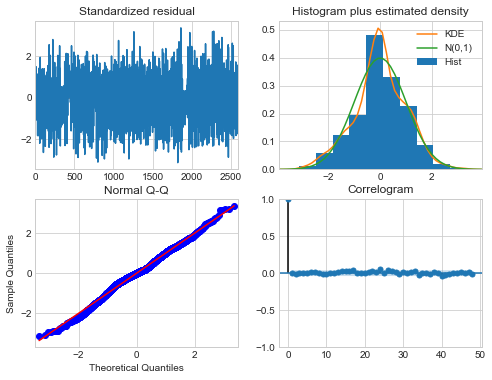

In [110]:
model4 = SARIMAX(y_train, order = (7,1,4),seasonal_order=(0,1,1,24),enforce_stationarity=False, 
                 enforce_invertibility=False,)
model4_fit = model4.fit(maxiter=1000,disp=False)
# print summary of fit model
print(model4_fit.summary())
model4_fit.plot_diagnostics(lags=48)
plt.show()

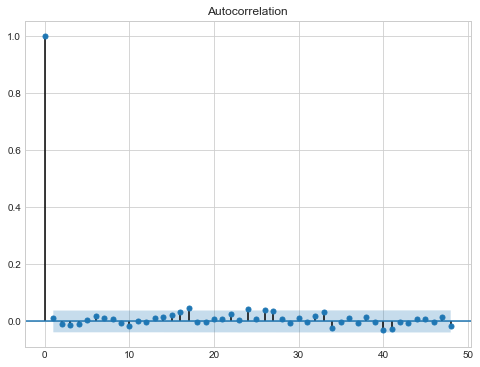

In [111]:
plot_acf(model4_fit.resid,lags=48)
plt.show()

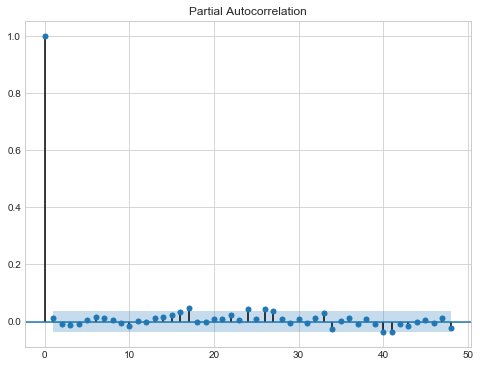

In [112]:
plot_pacf(model4_fit.resid,lags=48)
plt.show()

In [135]:
pred3 = model4_fit.forecast(643)
print('MAE: {}\nMSE: {}'.format(mean_absolute_error(y_test, pred3), mean_squared_error(y_test, pred3)))

MAE: 1.1210054750668177
MSE: 1.9103902573368854


In [137]:
pred3_nolog = np.exp(pred3)
print('MSE on non-log data: {}'.format(mean_squared_error(test['lights'], pred3_nolog)))

MSE on non-log data: 804.1236775494383


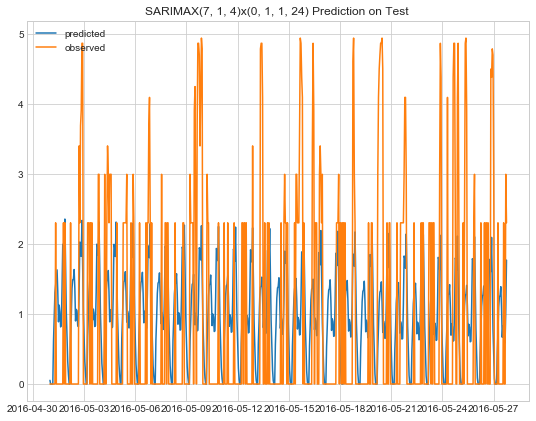

In [129]:
plt.figure(figsize=(9,7))
plt.plot(dfts['new_feat'][2647:],pred3, label='predicted')
plt.plot(dfts['new_feat'][2647:],y_test, label= 'observed')
plt.legend()
plt.title('SARIMAX(7, 1, 4)x(0, 1, 1, 24) Prediction on Test ')
plt.show()

In [138]:
mse_sarima = mean_squared_error(y_test, pred3)
mse_baseline = mean_squared_error(y_test, mean_predictor)
print('MSE Sarima Model / MSE Baseline: {}'.format((mse_sarima / mse_baseline)))

MSE Sarima Model / MSE Baseline: 0.6862493263926477


In [140]:
mse_sarima = mean_squared_error(test['lights'], pred3_nolog)
mse_baseline = mean_squared_error(test['lights'], mean)
print('NON LOG VALUES --> MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

NON LOG VALUES --> MSE Sarima Model / MSE Baseline: 0.8147796898890806


## Model goes under 0 with predictions, so i set these values equal to 0

In [132]:
pred3[pred3<0] = 0

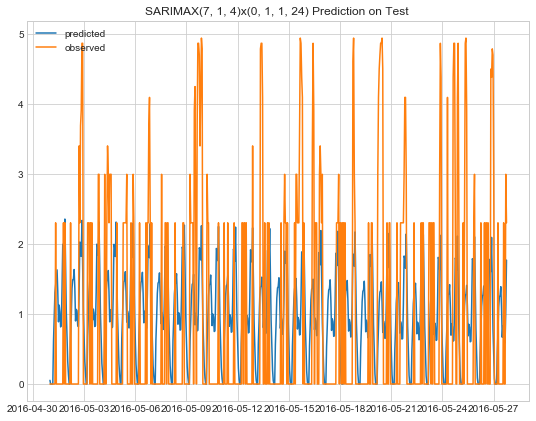

In [133]:
plt.figure(figsize=(9,7))
plt.plot(dfts['new_feat'][2647:],pred3, label='predicted')
plt.plot(dfts['new_feat'][2647:],y_test, label= 'observed')
plt.legend()
plt.title('SARIMAX(7, 1, 4)x(0, 1, 1, 24) Prediction on Test ')
plt.show()

In [142]:
mse_sarima = mean_squared_error(y_test, pred3)
mse_baseline = mean_squared_error(y_test, mean_predictor)
print('MSE Sarima Model / MSE Baseline: {}'.format(mse_sarima / mse_baseline))

MSE Sarima Model / MSE Baseline: 0.6862493263926477


# This is the best SARIMA MODEL, accordind to baseline benchmark:


* Model1 = SARIMAX(2,0,0)(1,1,1,24)   -->   MSE: 2.06626  |  MSE/MSE(Baseline)= 0.74549
* Model2 = SARIMAX(1,1,2)(1,1,1,24)   -->   MSE: 2.06868  |  MSE/MSE(Baseline)= 0.7463
* Model3 = SARIMAX(7,1,4)(0,1,1,24)   -->   MSE: 1.91039  |  MSE/MSE(Baseline)= 0.6892

<a id='section2'></a>

# UCM MODELS

## $y_{t+1} = μ_{t} + γ_{t} + ψ_{t} + \sum\limits_{i=0}^{k} β_{i}x_{it} + ε_{t}$

In [2]:
data = pd.read_csv('temp2.csv')
data['new_feat'] = pd.to_datetime(data['new_feat'])
data.head()

,new_feat,lights
0,2016-01-11 17:00:00,210
1,2016-01-11 18:00:00,310
2,2016-01-11 19:00:00,150
3,2016-01-11 20:00:00,210
4,2016-01-11 21:00:00,140


1st try with logarithmic response variable

In [3]:
#Set values==0 equal to 1 before log-transformation so i obtain 0 and not inf
logy = [np.log(data.iloc[i]['lights']) if data.iloc[i]['lights'] != 0 else 0 for i in data.index]
# dlogy = pd.Series(logy).diff()

In [4]:
len(logy)

3290

In [5]:
training = logy[:2647]
test = logy[2647:]

In [6]:
# training = data['lights'].iloc[:2647]
# test = data['lights'].iloc[2647:]

In [6]:
len(training), len(test)

(2647, 643)

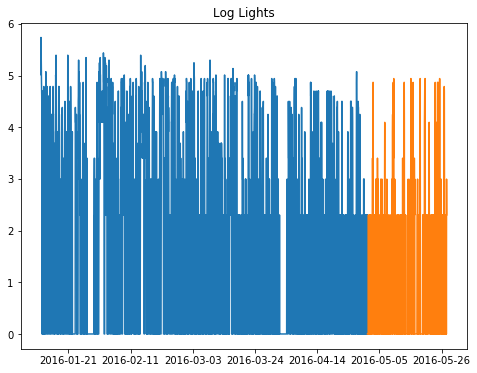

In [7]:
plt.figure(figsize=(8,6))
plt.plot(data['new_feat'][:2647], training)
plt.plot(data['new_feat'][2647:], test)
plt.title('Log Lights')
plt.show()

Nel modello UCM rimuovo lo slope (trend=False) e anche la componente ciclica, dato che la nostra ts raccoglie i dati di 5 mesi. Inoltre della componente level (locallineartrend) si è considerato solo il caso deterministico, rimuovendo la componente stocastica (stochastic_trend=False).

In [8]:
model_ucm = sm.tsa.UnobservedComponents(training,level=True,trend=False, seasonal=24,cycle=False,
                                        irregular=True, stochastic_level=False, stochastic_trend=False, 
                                        stochastic_seasonal=True, stochastic_cycle=False)

results = model_ucm.fit(maxiter=1000,disp=False)

                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                 2647
Model:                deterministic constant   Log Likelihood               -5147.680
                   + stochastic seasonal(24)   AIC                          10299.360
Date:                       Thu, 19 Sep 2019   BIC                          10311.105
Time:                               00:38:48   HQIC                         10303.614
Sample:                                    0                                         
                                      - 2647                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     2.8409      0.095     29.850      0

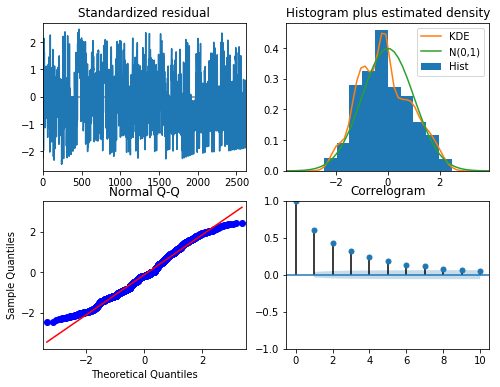

In [9]:
print(results.summary())
rcParams['figure.figsize'] = 8, 6
results.plot_diagnostics()
plt.show()

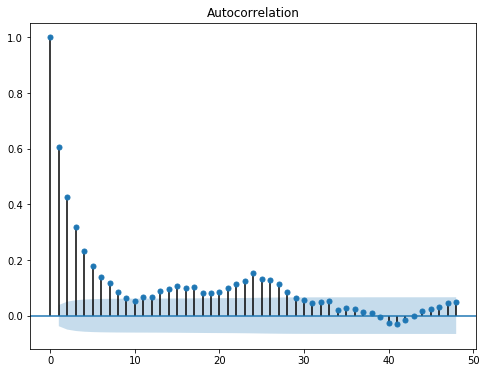

In [10]:
plot_acf(results.resid,lags=48)
plt.show()

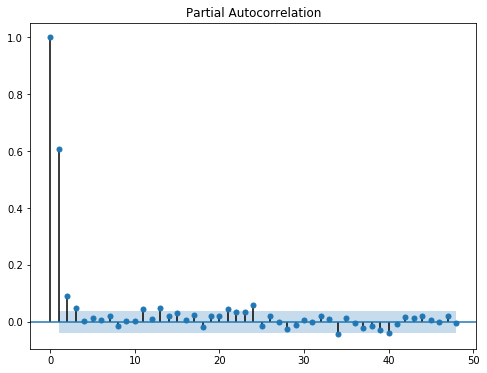

In [11]:
plot_pacf(results.resid,lags=48)
plt.show()

In [12]:
preds = results.predict(start=0, end=642)
preds[preds<0]=0
mean_squared_error(test, preds)

6.412954062507381

# Ecco l'errore: utilizzavo il metodo predict

In [12]:
preds = results.forecast(643)
preds[preds<0]=0
mean_squared_error(test, preds)

2.6070050647218648

In [13]:
basemodel = pd.Series(training).mean()
mean_squared_error(test, np.full(643, basemodel))

2.7716783322683343

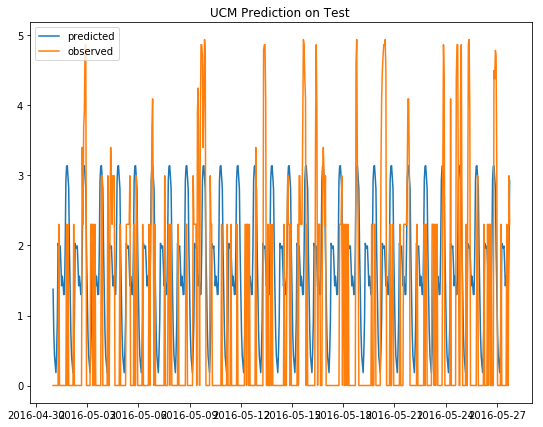

In [14]:
plt.figure(figsize=(9,7))
plt.plot(data['new_feat'][2647:],preds, label='predicted')
plt.plot(data['new_feat'][2647:],test, label= 'observed')
plt.legend()
plt.title('UCM Prediction on Test ')
plt.show()

#### I grafici ACF mostrano un decadimento geometrico dell'autocorrelazione. Si aggiunge dunque al modello una componente autoregressiva di ordine 3.

In [15]:
model_ucm2 = sm.tsa.UnobservedComponents(training,level=True,trend=False, seasonal=24,cycle=False, autoregressive=3,
                                        irregular=True, stochastic_level=False, stochastic_trend=False, 
                                        stochastic_seasonal=True, stochastic_cycle=False)

results = model_ucm2.fit(maxiter=1000,disp=False)

                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                 2647
Model:                deterministic constant   Log Likelihood               -4513.245
                   + stochastic seasonal(24)   AIC                           9038.489
                                     + AR(3)   BIC                           9073.722
Date:                       Thu, 19 Sep 2019   HQIC                          9051.249
Time:                               00:41:04                                         
Sample:                                    0                                         
                                      - 2647                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

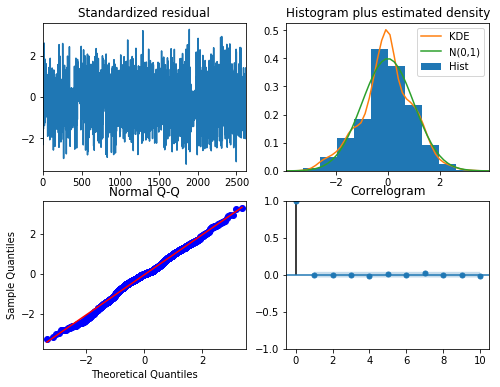

In [16]:
print(results.summary())
results.plot_diagnostics()
plt.show()

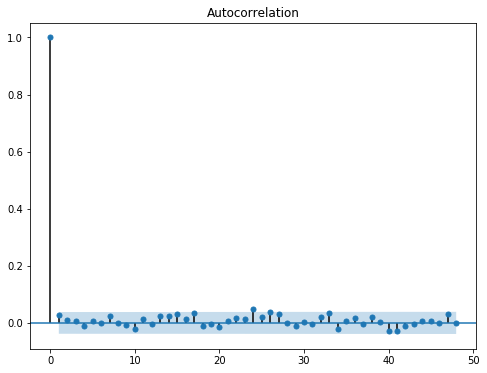

In [17]:
plot_acf(results.resid,lags=48)
plt.show()

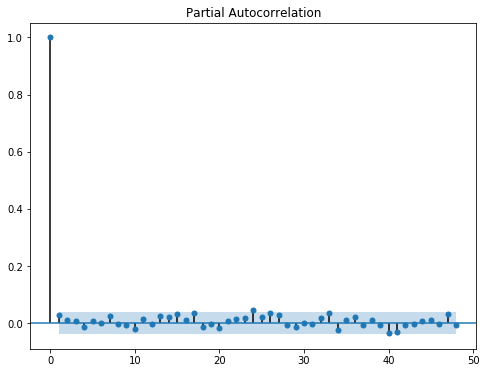

In [18]:
plot_pacf(results.resid,lags=48)
plt.show()

In [19]:
# preds = results.predict(start=0, end=642)
# preds[preds<0]=0
# mean_squared_error(test, preds)

# USE FORECAST

6.69233509920707

In [19]:
preds = results.forecast(643)
preds[preds<0]=0
mean_squared_error(test, preds)

2.555332364217513

In [20]:
basemodel = pd.Series(training).mean()
mean_squared_error(test, np.full(643, basemodel))

2.7716783322683343

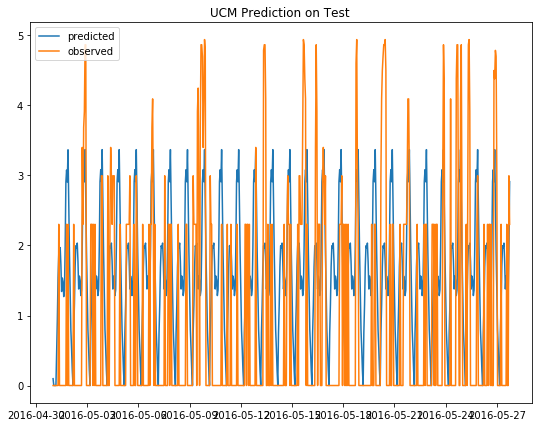

In [21]:
plt.figure(figsize=(9,7))
plt.plot(data['new_feat'][2647:],preds, label='predicted')
plt.plot(data['new_feat'][2647:],test, label= 'observed')
plt.legend()
plt.title('UCM Prediction on Test ')
plt.show()

In [22]:
print('Training mean for baseline model: {:.3f}'.format(basemodel))
mean_predictor = np.full((643),basemodel)
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(mse_baseline))
print('-'*40)
mse_NN = mean_squared_error(test, preds)
print('MSE UCM model {:.3f}'.format(mean_squared_error(test, preds)))
print('MSE UCM Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 1.672
MSE baseline model: 2.772
----------------------------------------
MSE UCM model 2.555
MSE UCM Model / MSE Baseline: 0.922


Aggiungo anche una parte di trend deterministico

                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                 2647
Model:                   deterministic trend   Log Likelihood               -4511.652
                   + stochastic seasonal(24)   AIC                           9035.304
                                     + AR(3)   BIC                           9070.534
Date:                       Thu, 19 Sep 2019   HQIC                          9048.063
Time:                               00:46:10                                         
Sample:                                    0                                         
                                      - 2647                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

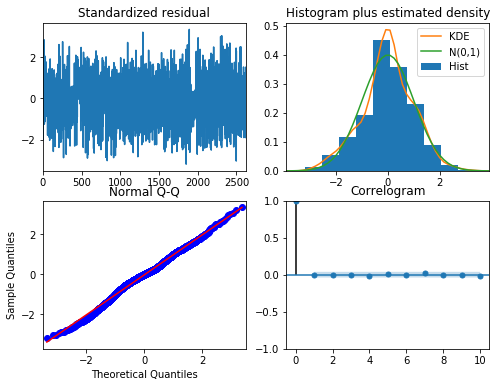

In [29]:
#Deterministic Level component
model_ucm = sm.tsa.UnobservedComponents(training,level=True,trend=True, seasonal=24,cycle=False, autoregressive=3,
                                        irregular=True, stochastic_level=False, stochastic_trend=False, 
                                        stochastic_seasonal=True, stochastic_cycle=False)

results = model_ucm.fit(maxiter=1000,disp=False)
print(results.summary())
results.plot_diagnostics()
plt.show()

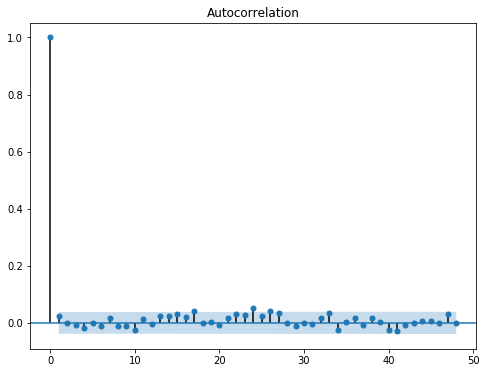

In [31]:
rcParams['figure.figsize'] = 8, 6
plot_acf(results.resid, lags=48)
plt.show()

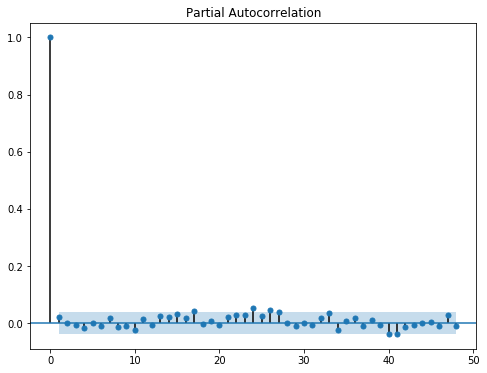

In [32]:
plot_pacf(results.resid, lags=48)
plt.show()

In [33]:
preds = results.forecast(643)
preds[preds<0]=0
mean_squared_error(test, preds)

2.014489447697692

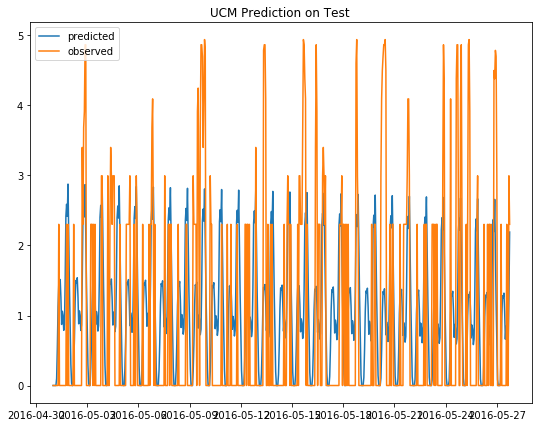

In [34]:
plt.figure(figsize=(9,7))
plt.plot(data['new_feat'][2647:],preds, label='predicted')
plt.plot(data['new_feat'][2647:],test, label= 'observed')
plt.legend()
plt.title('UCM Prediction on Test ')
plt.show()

In [35]:
print('Training mean for baseline model: {:.3f}'.format(basemodel))
mean_predictor = np.full((643),basemodel)
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(mse_baseline))
print('-'*40)
mse_NN = mean_squared_error(test, preds)
print('MSE UCM model {:.3f}'.format(mean_squared_error(test, preds)))
print('MSE UCM Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 1.672
MSE baseline model: 2.772
----------------------------------------
MSE UCM model 2.014
MSE UCM Model / MSE Baseline: 0.727


<a id='section3'></a>

## RNN MODELS 
<img src="pics/Pytorch.png" style="width:400px;height:100px;">

Data Loading

In [2]:
tsdata = pd.read_csv('temp2.csv')
tsdata.head()

,new_feat,lights
0,2016-01-11 17,210
1,2016-01-11 18,310
2,2016-01-11 19,150
3,2016-01-11 20,210
4,2016-01-11 21,140


In [3]:
ts, data = load_data('temp2.csv', 'lights')

time series shape: (3290, 1)


In [4]:
type(ts)

pandas.core.series.Series

In [5]:
type(data)

numpy.ndarray

In [6]:
tsdata.iloc[0]

new_feat    2016-01-11 17
lights                210
Name: 0, dtype: object

In [7]:
tsdata.iloc[-1]

new_feat    2016-05-27 18
lights                 10
Name: 3289, dtype: object

Training

In [8]:
tsdata.iloc[:1927]

,new_feat,lights
0,2016-01-11 17,210
1,2016-01-11 18,310
2,2016-01-11 19,150
3,2016-01-11 20,210
4,2016-01-11 21,140
5,2016-01-11 22,130
6,2016-01-11 23,110
7,2016-01-12 00,100
8,2016-01-12 01,50
9,2016-01-12 02,0


Validation

In [9]:
tsdata.iloc[1927:2647]

,new_feat,lights
1927,2016-04-01 00,0
1928,2016-04-01 01,0
1929,2016-04-01 02,0
1930,2016-04-01 03,0
1931,2016-04-01 04,0
1932,2016-04-01 05,0
1933,2016-04-01 06,0
1934,2016-04-01 07,10
1935,2016-04-01 08,0
1936,2016-04-01 09,0


Test

In [10]:
tsdata.iloc[2647:]

,new_feat,lights
2647,2016-05-01 00,0
2648,2016-05-01 01,0
2649,2016-05-01 02,0
2650,2016-05-01 03,0
2651,2016-05-01 04,0
2652,2016-05-01 05,0
2653,2016-05-01 06,0
2654,2016-05-01 07,0
2655,2016-05-01 08,10
2656,2016-05-01 09,0


In [11]:
training = data[:1927]
validation = data[1927:2647]
test = data[2647:]

In [12]:
lag = 24
flag = True
trainX, trainY = createSamples(training, lag, RNN=flag)
validX, validY = createSamples(validation, lag, RNN=flag)
testX, testY = createSamples(test, lag, RNN=flag)
print("testX shape:", testX.shape)
print("testy shape:", testY.shape)
print("validX shape:", validX.shape)
print("validy shape:", validY.shape)
print("trainX shape:", trainX.shape)
print("trainy shape:", trainY.shape)

testX shape: (619, 24, 1)
testy shape: (619, 1)
validX shape: (696, 24, 1)
validy shape: (696, 1)
trainX shape: (1903, 24, 1)
trainy shape: (1903, 1)


In [13]:
trainX[0]

array([[210.],
       [310.],
       [150.],
       [210.],
       [140.],
       [130.],
       [110.],
       [100.],
       [ 50.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 20.],
       [110.],
       [ 60.],
       [  0.],
       [ 10.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.]], dtype=float32)

In [14]:
trainY[0]

array([120.], dtype=float32)

In [15]:
tsdata.iloc[24]

new_feat    2016-01-12 17
lights                120
Name: 24, dtype: object

The lag window consists in 24 h, so the model takes the previous 24h as input to predict the next one

#### Standardization of inputs

In [16]:
print('Training --> mean: {}\tstd:{}\nValidation --> mean:{}\tstd:{}\nTest --> mean: {}\tstd: {}'.format(
        trainX.mean(),trainX.std(),validX.mean(), validX.std(),testX.mean(),testX.std()))

Training --> mean: 29.62778091430664	std:46.49726867675781
Validation --> mean:14.8970308303833	std:29.115947723388672
Test --> mean: 10.829294204711914	std: 28.19295310974121


In [17]:
trainX = stats.zscore(trainX)
validX = stats.zscore(validX)
testX = stats.zscore(testX)

Dataloaders

In [18]:
dataset = Time_Series_Data(trainX, trainY)
datasetval = Time_Series_Data(validX, validY)
datasetest = Time_Series_Data(testX, testY)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=512, sampler=None, 
                                         batch_sampler=None, num_workers=4)
validloader = torch.utils.data.DataLoader(datasetval, batch_size=128, sampler=None, 
                                         batch_sampler=None, num_workers=4)
testloader = torch.utils.data.DataLoader(datasetest, batch_size=128, sampler=None, 
                                         batch_sampler=None, num_workers=4)

In [19]:
#batches
print(len(trainloader))
print(len(validloader))
print(len(testloader))

4
6
5


In [20]:
next(iter(trainloader))[0]

tensor([[[ 3.7926e+00],
         [ 5.9263e+00],
         [ 2.5656e+00],
         ...,
         [-6.3631e-01],
         [-6.3659e-01],
         [-6.3659e-01]],

        [[ 5.9021e+00],
         [ 2.5386e+00],
         [ 3.8477e+00],
         ...,
         [-6.3631e-01],
         [-6.3659e-01],
         [ 1.9519e+00]],

        [[ 2.5269e+00],
         [ 3.8090e+00],
         [ 2.3519e+00],
         ...,
         [-6.3631e-01],
         [ 1.9519e+00],
         [ 1.5205e+00]],

        ...,

        [[ 2.1050e+00],
         [ 2.1152e+00],
         [ 2.1382e+00],
         ...,
         [ 2.1677e+00],
         [ 3.2462e+00],
         [ 2.3834e+00]],

        [[ 2.1050e+00],
         [ 2.1152e+00],
         [ 1.3475e-03],
         ...,
         [ 3.2462e+00],
         [ 2.3834e+00],
         [ 2.3834e+00]],

        [[ 2.1050e+00],
         [-2.1139e-03],
         [-6.3971e-01],
         ...,
         [ 2.3834e+00],
         [ 2.3834e+00],
         [ 2.1677e+00]]])

#### Training function

In [20]:
def train(trainX, trainY, validX, validY,  lag, lr, method, hidden_num=64, num_epochs=20,batchSize=32,
          checkPoint=15, use_cuda=False, scheduler=False):
    
    LOSS_LOGGER_TRAIN = {}
    LOSS_LOGGER_VALID = {}
    dataset = Time_Series_Data(trainX, trainY)
    datasetval = Time_Series_Data(validX, validY)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, sampler=None, 
                                              batch_sampler=None, num_workers=1)
    validloader = torch.utils.data.DataLoader(datasetval, batch_size=128, sampler=None, 
                                              batch_sampler=None, num_workers=1)

    net = None
    if method == "RNN":
        net = RNNModel(inputDim=1, hiddenNum=hidden_num, outputDim=1, layerNum=1, cell="RNN", use_cuda=use_cuda)
    if method == "LSTM":
        net = LSTMModel(inputDim=1, hiddenNum=hidden_num, outputDim=1, layerNum=1, cell="LSTM", use_cuda=use_cuda)
    if method == "GRU":
        net = GRUModel(inputDim=1, hiddenNum=hidden_num, outputDim=1, layerNum=1, cell="GRU", use_cuda=use_cuda)
    
    best_model_wts = copy.deepcopy(net.state_dict()) #I will use this to save best model
    best_loss = 1e10 #set very high loss
    
    if use_cuda:
        net = net.cuda()

    optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=0.9)
    criterion = nn.MSELoss()
    
    if scheduler:
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma= 0.5) #If wanted, change params

    t1 = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 45)
        
        for phase in ['training', 'validation']:
            
            if phase == 'training':
                
                if scheduler:
                    exp_lr_scheduler.step()
                    if (epoch+1) % exp_lr_scheduler.step_size == 0:
                        print('Learning Rate Scheduler divides lr by a gamma of {:.1f}.\n'.format(
                              exp_lr_scheduler.gamma))
                
                chekloss = []       
                net = net.train()
                for batch_idx, (x, y) in enumerate(trainloader):

                    x, y = Variable(x), Variable(y)
                    if use_cuda:
                        x = x.cuda()
                        y = y.cuda()

                    optimizer.zero_grad()

                    pred = net.forward(x)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()
                    
                    chekloss.append(loss.mean().item())
                    
                    if batch_idx % checkPoint == 0 and batch_idx != 0:
                        print('Training Iteration: {:>3} | Loss : {:>4.3f} |'.format(batch_idx, np.mean(chekloss)))

                print('Training EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, np.mean(chekloss)))
                LOSS_LOGGER_TRAIN.update({epoch+1:np.mean(chekloss)})
            
            else:
                      
                net.eval()
                chekloss = []
                
                for batch_idx, (x, y) in enumerate(validloader):

                    x, y = Variable(x), Variable(y)
                    if use_cuda:
                        x = x.cuda()
                        y = y.cuda()

                    pred = net.forward(x)
                    loss = criterion(pred, y)
                    
                    chekloss.append(loss.mean().item())
                
                epoch_loss = np.mean(chekloss)
                print('Validation EP#{} --> | Loss: {:>4.3f} |'.format(epoch+1, epoch_loss))  
                LOSS_LOGGER_VALID.update({epoch+1:epoch_loss})
                print('-'*45)
                      
                      
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(net.state_dict())#Return model weights with best performance on valid
        print()
                      
    time_elapsed = time.time() - t1
    print('Training completed in {:.0f}min and {:.0f}sec\nBest validation Loss: {:.3f}'.format(time_elapsed // 60,
                                                                 time_elapsed % 60, best_loss))
    
    net.load_state_dict(best_model_wts)
    
    return net, LOSS_LOGGER_TRAIN, LOSS_LOGGER_VALID

#### Prediction function

In [21]:
def predict(net, testX, use_cuda=False):

    if use_cuda:
        net = net.cuda()
    net = net.eval()
    testX = torch.from_numpy(testX)
    testX = Variable(testX)
    if use_cuda:
        testX = testX.cuda()
    pred = net(testX)
    if use_cuda:
        pred = pred.cpu()
    return pred.data.numpy()

forward predictions

In [22]:
def predict_iteration(net, testX, lookAhead=1, RNN=True, use_cuda=True):

    testBatchSize = testX.shape[0]
    ans = []

    for i in range(lookAhead):

        testX_torch = torch.from_numpy(testX)
        testX_torch = Variable(testX_torch)
        if use_cuda:
            testX_torch = testX_torch.cuda()
        pred = net(testX_torch)
        if use_cuda:
            pred = pred.cpu().data.numpy()
        else:
            pred = pred.data.numpy()
        pred = np.squeeze(pred)
        ans.append(pred)

        testX = testX[:, 1:]  # drop the head
        if RNN:
            pred = pred.reshape((testBatchSize, 1, 1))
            testX = np.append(testX, pred, axis=1)  # add the prediction to the tail
        else:
            pred = pred.reshape((testBatchSize, 1))
            testX = np.append(testX, pred, axis=1)  # add the prediction to the tail
    ans = np.array(ans)
    ans = ans.transpose([1, 0])
    return ans

## Training:

#### RNN

In [23]:
model, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='RNN', 
                                    checkPoint=10,use_cuda=True)

RNN(1, 64, batch_first=True)
Epoch 1/20
---------------------------------------------
Training Iteration:  10 | Loss : 2420.663 |
Training Iteration:  20 | Loss : 2712.893 |
Training Iteration:  30 | Loss : 2649.282 |
Training Iteration:  40 | Loss : 2530.235 |
Training Iteration:  50 | Loss : 2419.235 |
Training EP#1 --> | Loss: 2286.754 |
Validation EP#1 --> | Loss: 1053.331 |
---------------------------------------------

Epoch 2/20
---------------------------------------------
Training Iteration:  10 | Loss : 1940.138 |
Training Iteration:  20 | Loss : 2428.099 |
Training Iteration:  30 | Loss : 2475.331 |
Training Iteration:  40 | Loss : 2377.838 |
Training Iteration:  50 | Loss : 2282.177 |
Training EP#2 --> | Loss: 2159.047 |
Validation EP#2 --> | Loss: 995.062 |
---------------------------------------------

Epoch 3/20
---------------------------------------------
Training Iteration:  10 | Loss : 1942.330 |
Training Iteration:  20 | Loss : 2426.818 |
Training Iteration:  30 | L

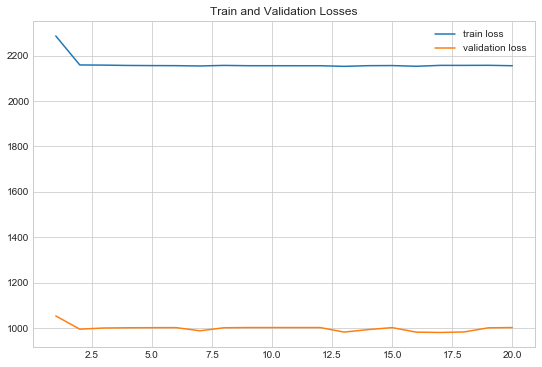

In [30]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses')
plt.show()

In [25]:
test_pred = predict(model, testX, use_cuda=True)

In [26]:
test_pred

array([[28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018646],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.019623],
       [28.018642],
       [28.020302],
       [28.021152],
       [28.042942],
       [28.041866],
       [28.018246],
       [28.018307],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018646],
       [28.018646],
       [28.018646],
       [28.018303],
       [28.018646],
       [28.018303],
       [28.018646],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.018303],
       [28.019077],
       [28.019073],
       [28.018303],
       [28.018303],
       [28.018303],


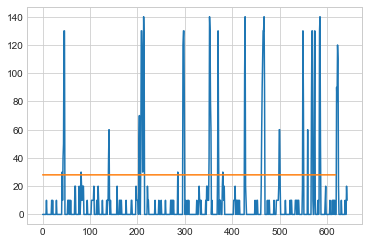

In [27]:
plt.plot(test)
plt.plot(test_pred)
plt.show()

Change params: set 32 hidden units

In [24]:
model2, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='RNN',hidden_num=32, 
                                     num_epochs=40,checkPoint=10,use_cuda=True, scheduler=True)

RNN(1, 32, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2554.744 |
Training Iteration:  20 | Loss : 2969.302 |
Training Iteration:  30 | Loss : 2913.681 |
Training Iteration:  40 | Loss : 2708.581 |
Training Iteration:  50 | Loss : 2543.818 |
Training EP#1 --> | Loss: 2374.144 |
Validation EP#1 --> | Loss: 953.466 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 1945.629 |
Training Iteration:  20 | Loss : 2424.628 |
Training Iteration:  30 | Loss : 2476.414 |
Training Iteration:  40 | Loss : 2376.060 |
Training Iteration:  50 | Loss : 2278.242 |
Training EP#2 --> | Loss: 2153.638 |
Validation EP#2 --> | Loss: 997.894 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1942.536 |
Training Iteration:  20 | Loss : 2412.555 |
Training Iteration:  30 | Lo

Training Iteration:  10 | Loss : 1150.703 |
Training Iteration:  20 | Loss : 1352.825 |
Training Iteration:  30 | Loss : 1374.373 |
Training Iteration:  40 | Loss : 1330.806 |
Training Iteration:  50 | Loss : 1265.989 |
Training EP#21 --> | Loss: 1212.664 |
Validation EP#21 --> | Loss: 570.702 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1136.689 |
Training Iteration:  20 | Loss : 1331.360 |
Training Iteration:  30 | Loss : 1352.609 |
Training Iteration:  40 | Loss : 1309.777 |
Training Iteration:  50 | Loss : 1247.254 |
Training EP#22 --> | Loss: 1195.963 |
Validation EP#22 --> | Loss: 586.872 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1126.185 |
Training Iteration:  20 | Loss : 1318.661 |
Training Iteration:  30 | Loss : 1339.627 |
Training Iteration:  40 | Loss : 1297.909 |
Training Iteration: 

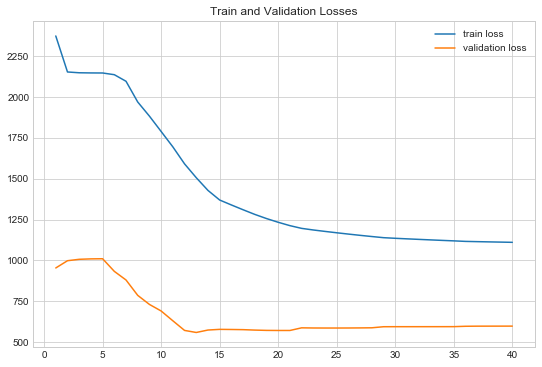

In [25]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses')
# plt.axis(ymin=400,ymax=3500)
plt.show()

## Ora devo attaccare al test le ultime 24 osservazioni del validation, in modo da far partire l'inferenza dal primo valore del test

In [23]:
print(validX.shape)
last24vals= validX[-24:,:]
last24vals.shape

(696, 24, 1)


(24, 24, 1)

In [24]:
testX.shape

(619, 24, 1)

In [25]:
#Xtest
finaltest = np.append(last24vals, testX, axis=0)
finaltest.shape

(643, 24, 1)

In [26]:
#Ytest
ylast24vals= validY[-24:,]
yfinaltest = np.append(ylast24vals, testY, axis=0)
yfinaltest.shape

(643, 1)

-------------

Inference on test

In [32]:
pred = predict_iteration(model2,finaltest,lookAhead=643)

In [33]:
tsdata['new_feat'] = pd.to_datetime(tsdata['new_feat'])

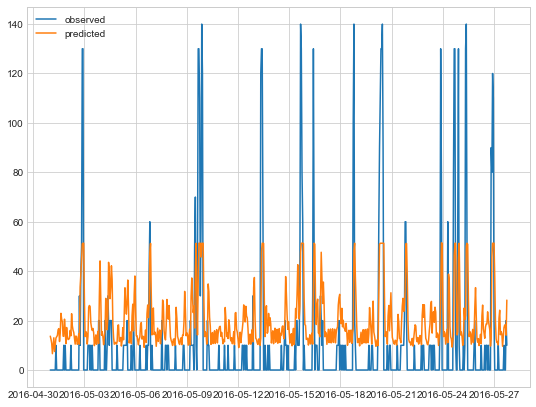

In [37]:
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [38]:
mean_squared_error(test,new_pred)

623.5736

In [39]:
training.mean()

29.979242

In [41]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE RNN model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE RNN Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE RNN model 623.574
MSE RNN Model / MSE Baseline: 0.541


Normal predict

In [42]:
c = predict(model2,finaltest,use_cuda=True)

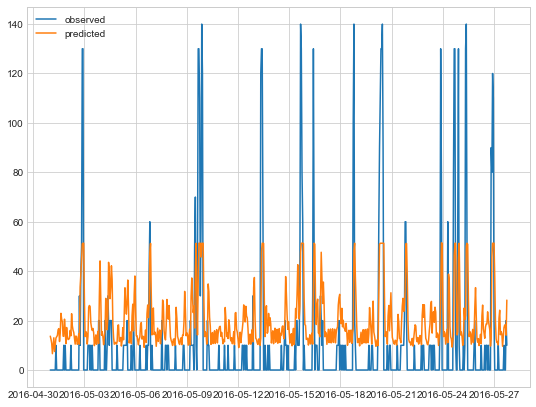

In [43]:
new_pred = c[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [44]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(mse_baseline))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE RNN model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE RNN Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.073
----------------------------------------
MSE RNN model 623.574
MSE RNN Model / MSE Baseline: 0.541


Same results

## LSTM

In [45]:
model3, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='LSTM',hidden_num=32, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

LSTM(1, 32, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2616.771 |
Training Iteration:  20 | Loss : 3020.287 |
Training Iteration:  30 | Loss : 2948.370 |
Training Iteration:  40 | Loss : 2734.408 |
Training Iteration:  50 | Loss : 2564.979 |
Training EP#1 --> | Loss: 2394.041 |
Validation EP#1 --> | Loss: 970.098 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 1944.002 |
Training Iteration:  20 | Loss : 2420.222 |
Training Iteration:  30 | Loss : 2471.494 |
Training Iteration:  40 | Loss : 2372.637 |
Training Iteration:  50 | Loss : 2275.831 |
Training EP#2 --> | Loss: 2152.192 |
Validation EP#2 --> | Loss: 1002.493 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1942.434 |
Training Iteration:  20 | Loss : 2411.858 |
Training Iteration:  30 | 

Training Iteration:  10 | Loss : 1127.537 |
Training Iteration:  20 | Loss : 1350.750 |
Training Iteration:  30 | Loss : 1362.302 |
Training Iteration:  40 | Loss : 1314.361 |
Training Iteration:  50 | Loss : 1249.709 |
Training EP#21 --> | Loss: 1200.833 |
Validation EP#21 --> | Loss: 594.788 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1117.186 |
Training Iteration:  20 | Loss : 1326.657 |
Training Iteration:  30 | Loss : 1338.976 |
Training Iteration:  40 | Loss : 1293.100 |
Training Iteration:  50 | Loss : 1229.750 |
Training EP#22 --> | Loss: 1183.234 |
Validation EP#22 --> | Loss: 595.450 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1118.618 |
Training Iteration:  20 | Loss : 1316.693 |
Training Iteration:  30 | Loss : 1327.313 |
Training Iteration:  40 | Loss : 1282.366 |
Training Iteration: 

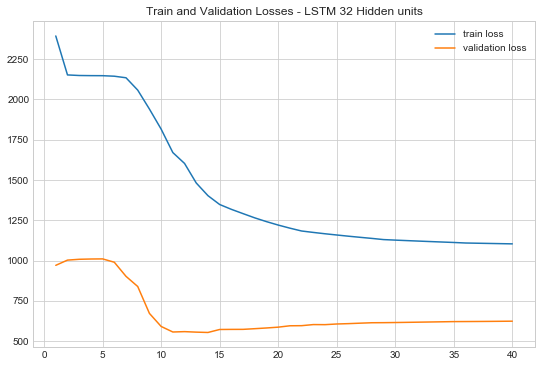

In [46]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - LSTM 32 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

Prediction with the last value predicted

In [55]:
test.shape

(643, 1)

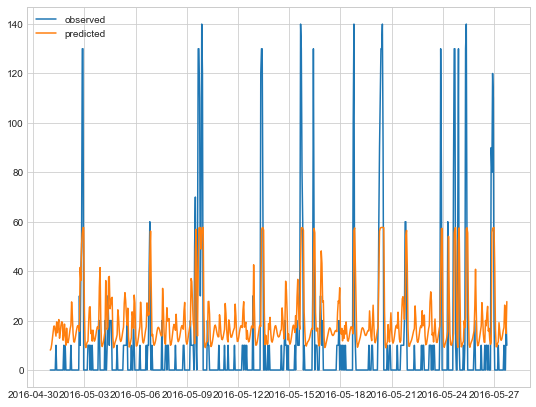

In [56]:
pred = predict_iteration(model3,finaltest,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [57]:
mean_squared_error(test,new_pred)

587.33636

In [58]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE LSTM model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE LSTM Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE LSTM model 587.336
MSE LSTM Model / MSE Baseline: 0.510


Normal predict

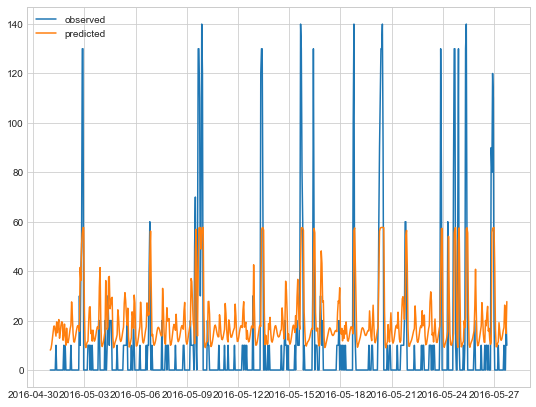

In [50]:
c = predict(model3,finaltest,use_cuda=True)
new_pred = c[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [51]:
mean_squared_error(test,new_pred)

587.33636

In [52]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE LSTM model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE LSTM Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE LSTM model 587.336
MSE LSTM Model / MSE Baseline: 0.510


#### Change LSTM params reducing hidden units to 16

In [53]:
model4, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='LSTM',hidden_num=16, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

LSTM(1, 16, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2663.658 |
Training Iteration:  20 | Loss : 3164.963 |
Training Iteration:  30 | Loss : 3150.702 |
Training Iteration:  40 | Loss : 2917.075 |
Training Iteration:  50 | Loss : 2723.809 |
Training EP#1 --> | Loss: 2515.984 |
Validation EP#1 --> | Loss: 812.760 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 2017.306 |
Training Iteration:  20 | Loss : 2539.960 |
Training Iteration:  30 | Loss : 2602.836 |
Training Iteration:  40 | Loss : 2474.691 |
Training Iteration:  50 | Loss : 2356.087 |
Training EP#2 --> | Loss: 2207.735 |
Validation EP#2 --> | Loss: 885.003 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1961.687 |
Training Iteration:  20 | Loss : 2457.802 |
Training Iteration:  30 | L

Training Iteration:  10 | Loss : 1138.529 |
Training Iteration:  20 | Loss : 1353.260 |
Training Iteration:  30 | Loss : 1377.600 |
Training Iteration:  40 | Loss : 1334.016 |
Training Iteration:  50 | Loss : 1266.425 |
Training EP#21 --> | Loss: 1212.216 |
Validation EP#21 --> | Loss: 574.623 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1132.674 |
Training Iteration:  20 | Loss : 1341.453 |
Training Iteration:  30 | Loss : 1365.318 |
Training Iteration:  40 | Loss : 1323.166 |
Training Iteration:  50 | Loss : 1256.234 |
Training EP#22 --> | Loss: 1203.278 |
Validation EP#22 --> | Loss: 576.040 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1130.189 |
Training Iteration:  20 | Loss : 1336.128 |
Training Iteration:  30 | Loss : 1359.260 |
Training Iteration:  40 | Loss : 1317.582 |
Training Iteration: 

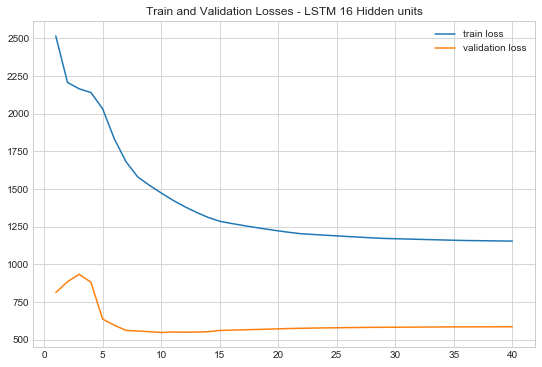

In [63]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - LSTM 16 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

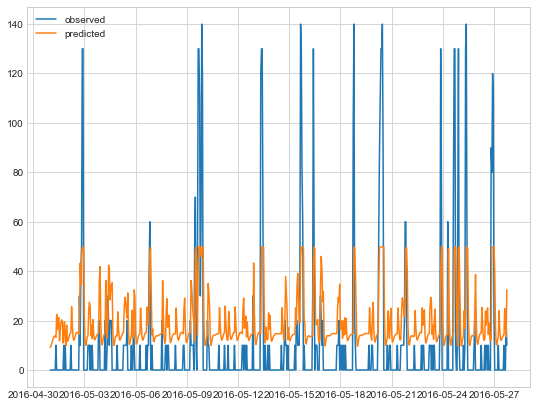

In [61]:
#Prediction with predicted value
pred = predict_iteration(model4,finaltest,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [62]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE LSTM model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE LSTM Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE LSTM model 605.490
MSE LSTM Model / MSE Baseline: 0.526


LSTM with 64 hidden units

In [23]:
model5, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='LSTM',hidden_num=64, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

LSTM(1, 64, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2460.687 |
Training Iteration:  20 | Loss : 2728.025 |
Training Iteration:  30 | Loss : 2657.111 |
Training Iteration:  40 | Loss : 2536.128 |
Training Iteration:  50 | Loss : 2423.275 |
Training EP#1 --> | Loss: 2289.232 |
Validation EP#1 --> | Loss: 1046.311 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 1940.150 |
Training Iteration:  20 | Loss : 2429.254 |
Training Iteration:  30 | Loss : 2476.773 |
Training Iteration:  40 | Loss : 2378.734 |
Training Iteration:  50 | Loss : 2282.758 |
Training EP#2 --> | Loss: 2159.469 |
Validation EP#2 --> | Loss: 995.495 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1942.301 |
Training Iteration:  20 | Loss : 2426.099 |
Training Iteration:  30 | 

Training Iteration:  10 | Loss : 1936.871 |
Training Iteration:  20 | Loss : 2393.733 |
Training Iteration:  30 | Loss : 2444.929 |
Training Iteration:  40 | Loss : 2350.086 |
Training Iteration:  50 | Loss : 2255.400 |
Training EP#21 --> | Loss: 2133.719 |
Validation EP#21 --> | Loss: 1004.610 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1935.290 |
Training Iteration:  20 | Loss : 2388.719 |
Training Iteration:  30 | Loss : 2440.573 |
Training Iteration:  40 | Loss : 2345.970 |
Training Iteration:  50 | Loss : 2251.605 |
Training EP#22 --> | Loss: 2130.182 |
Validation EP#22 --> | Loss: 1005.901 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1933.839 |
Training Iteration:  20 | Loss : 2386.700 |
Training Iteration:  30 | Loss : 2438.621 |
Training Iteration:  40 | Loss : 2344.282 |
Training Iteration

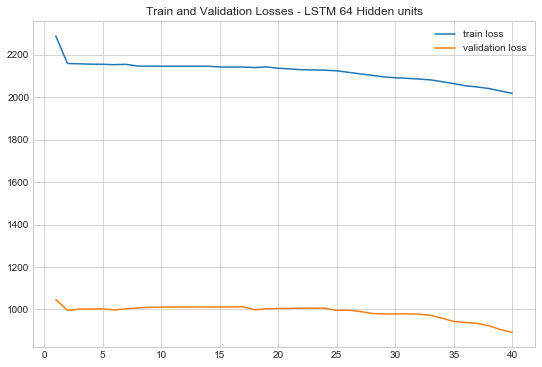

In [24]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - LSTM 64 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

bad results

In [ ]:
pred = predict_iteration(model5,,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (643,) and (619,)

In [64]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE GRU model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE GRU Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE GRU model 634.596
MSE GRU Model / MSE Baseline: 0.551


Model3, with 32 hidden units, is the best *LSTM* model

### GRU

In [27]:
model6, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='GRU',hidden_num=32, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

GRU(1, 32, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2588.678 |
Training Iteration:  20 | Loss : 2983.042 |
Training Iteration:  30 | Loss : 2914.009 |
Training Iteration:  40 | Loss : 2704.505 |
Training Iteration:  50 | Loss : 2536.032 |
Training EP#1 --> | Loss: 2364.897 |
Validation EP#1 --> | Loss: 937.153 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 1903.196 |
Training Iteration:  20 | Loss : 2362.703 |
Training Iteration:  30 | Loss : 2407.606 |
Training Iteration:  40 | Loss : 2307.301 |
Training Iteration:  50 | Loss : 2207.482 |
Training EP#2 --> | Loss: 2083.836 |
Validation EP#2 --> | Loss: 937.820 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1844.721 |
Training Iteration:  20 | Loss : 2287.161 |
Training Iteration:  30 | Lo

Training Iteration:  10 | Loss : 1169.388 |
Training Iteration:  20 | Loss : 1412.627 |
Training Iteration:  30 | Loss : 1462.911 |
Training Iteration:  40 | Loss : 1433.388 |
Training Iteration:  50 | Loss : 1368.566 |
Training EP#21 --> | Loss: 1303.091 |
Validation EP#21 --> | Loss: 680.842 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1153.359 |
Training Iteration:  20 | Loss : 1390.336 |
Training Iteration:  30 | Loss : 1440.291 |
Training Iteration:  40 | Loss : 1412.885 |
Training Iteration:  50 | Loss : 1348.898 |
Training EP#22 --> | Loss: 1285.236 |
Validation EP#22 --> | Loss: 669.837 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1145.271 |
Training Iteration:  20 | Loss : 1378.354 |
Training Iteration:  30 | Loss : 1428.389 |
Training Iteration:  40 | Loss : 1402.124 |
Training Iteration: 

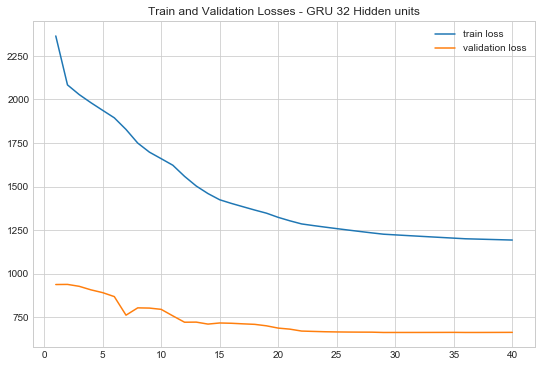

In [28]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - GRU 32 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

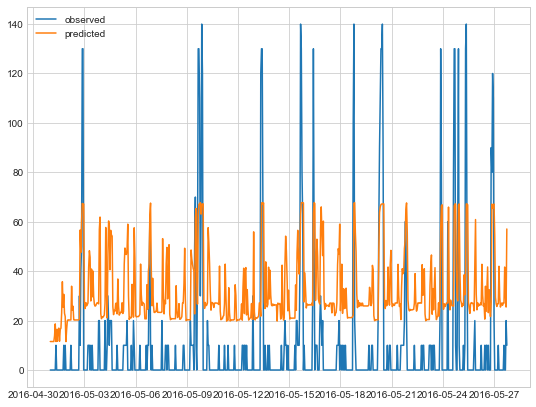

In [31]:
pred = predict_iteration(model6,finaltest,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [32]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE GRU model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE GRU Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE GRU model 979.761
MSE GRU Model / MSE Baseline: 0.850


Set hidden units to 16

In [33]:
model7, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='GRU',hidden_num=16, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

GRU(1, 16, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2651.525 |
Training Iteration:  20 | Loss : 3181.329 |
Training Iteration:  30 | Loss : 3183.183 |
Training Iteration:  40 | Loss : 2951.430 |
Training Iteration:  50 | Loss : 2757.861 |
Training EP#1 --> | Loss: 2545.128 |
Validation EP#1 --> | Loss: 795.631 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 2050.757 |
Training Iteration:  20 | Loss : 2585.535 |
Training Iteration:  30 | Loss : 2650.446 |
Training Iteration:  40 | Loss : 2514.326 |
Training Iteration:  50 | Loss : 2389.614 |
Training EP#2 --> | Loss: 2234.321 |
Validation EP#2 --> | Loss: 860.669 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1973.733 |
Training Iteration:  20 | Loss : 2478.612 |
Training Iteration:  30 | Lo

Training Iteration:  10 | Loss : 1212.134 |
Training Iteration:  20 | Loss : 1463.908 |
Training Iteration:  30 | Loss : 1502.381 |
Training Iteration:  40 | Loss : 1450.894 |
Training Iteration:  50 | Loss : 1379.230 |
Training EP#21 --> | Loss: 1309.256 |
Validation EP#21 --> | Loss: 596.298 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1202.471 |
Training Iteration:  20 | Loss : 1447.453 |
Training Iteration:  30 | Loss : 1485.734 |
Training Iteration:  40 | Loss : 1436.034 |
Training Iteration:  50 | Loss : 1365.431 |
Training EP#22 --> | Loss: 1297.124 |
Validation EP#22 --> | Loss: 598.605 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1197.743 |
Training Iteration:  20 | Loss : 1439.248 |
Training Iteration:  30 | Loss : 1476.660 |
Training Iteration:  40 | Loss : 1427.649 |
Training Iteration: 

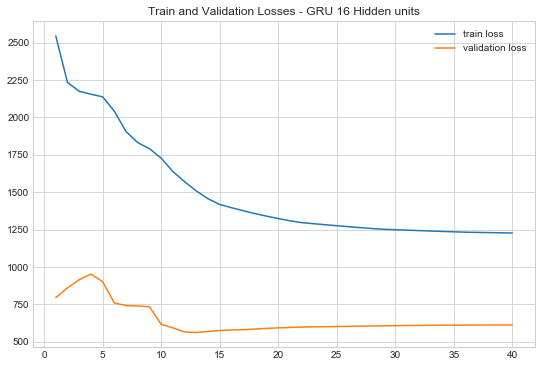

In [34]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - GRU 16 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

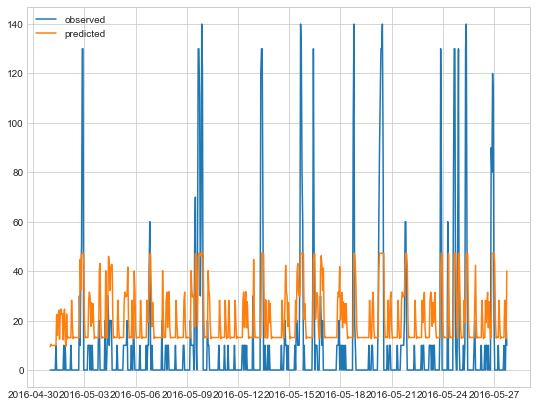

In [35]:
pred = predict_iteration(model7,finaltest,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [36]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE GRU model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE GRU Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE GRU model 659.655
MSE GRU Model / MSE Baseline: 0.573


Set 64 hidden units

In [37]:
model8, train_mse, valid_mse = train(trainX, trainY, validX,validY, lag, lr=1e-3, method='GRU',hidden_num=64, 
                                     num_epochs=40, checkPoint=10,use_cuda=True, scheduler=True)

GRU(1, 64, batch_first=True)
Epoch 1/40
---------------------------------------------
Training Iteration:  10 | Loss : 2423.377 |
Training Iteration:  20 | Loss : 2700.152 |
Training Iteration:  30 | Loss : 2628.608 |
Training Iteration:  40 | Loss : 2501.745 |
Training Iteration:  50 | Loss : 2379.468 |
Training EP#1 --> | Loss: 2239.999 |
Validation EP#1 --> | Loss: 964.793 |
---------------------------------------------

Epoch 2/40
---------------------------------------------
Training Iteration:  10 | Loss : 1821.231 |
Training Iteration:  20 | Loss : 2258.654 |
Training Iteration:  30 | Loss : 2288.748 |
Training Iteration:  40 | Loss : 2186.412 |
Training Iteration:  50 | Loss : 2084.518 |
Training EP#2 --> | Loss: 1965.791 |
Validation EP#2 --> | Loss: 843.937 |
---------------------------------------------

Epoch 3/40
---------------------------------------------
Training Iteration:  10 | Loss : 1694.397 |
Training Iteration:  20 | Loss : 2091.188 |
Training Iteration:  30 | Lo

Training Iteration:  10 | Loss : 1136.327 |
Training Iteration:  20 | Loss : 1334.569 |
Training Iteration:  30 | Loss : 1387.714 |
Training Iteration:  40 | Loss : 1369.021 |
Training Iteration:  50 | Loss : 1306.948 |
Training EP#21 --> | Loss: 1251.172 |
Validation EP#21 --> | Loss: 782.615 |
---------------------------------------------

Epoch 22/40
---------------------------------------------
Training Iteration:  10 | Loss : 1133.579 |
Training Iteration:  20 | Loss : 1326.185 |
Training Iteration:  30 | Loss : 1379.488 |
Training Iteration:  40 | Loss : 1361.656 |
Training Iteration:  50 | Loss : 1299.800 |
Training EP#22 --> | Loss: 1244.803 |
Validation EP#22 --> | Loss: 767.561 |
---------------------------------------------

Epoch 23/40
---------------------------------------------
Training Iteration:  10 | Loss : 1131.967 |
Training Iteration:  20 | Loss : 1322.552 |
Training Iteration:  30 | Loss : 1375.835 |
Training Iteration:  40 | Loss : 1358.252 |
Training Iteration: 

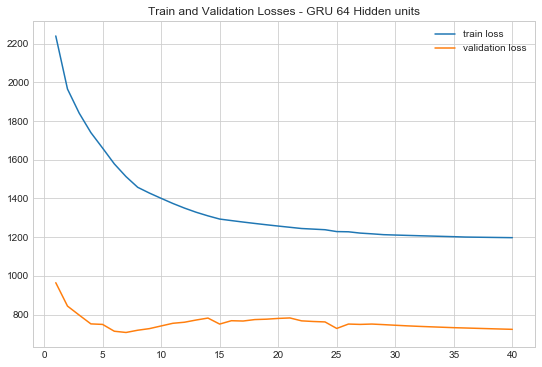

In [38]:
#LOSSES
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
plt.plot(*zip(*sorted(train_mse.items())),label='train loss')
plt.plot(*zip(*sorted(valid_mse.items())),label='validation loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Losses - GRU 64 Hidden units')
# plt.axis(ymin=400,ymax=3500)
plt.show()

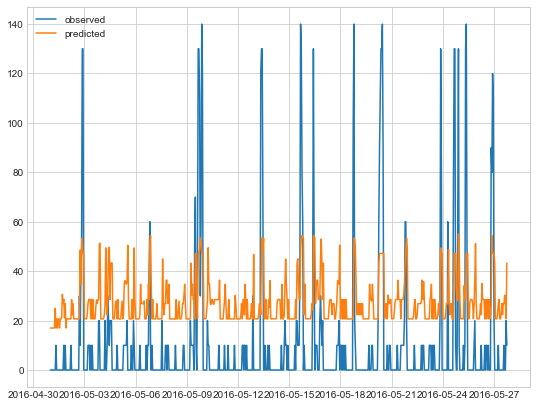

In [39]:
pred = predict_iteration(model8,finaltest,lookAhead=643)
new_pred = pred[:,0]
plt.figure(figsize=(9,7))
plt.plot(tsdata[2647:]['new_feat'],test,label='observed')
plt.plot(tsdata[2647:]['new_feat'],new_pred,label='predicted')
plt.legend(loc=2)
plt.show()

In [40]:
print('Training mean for baseline model: {:.3f}'.format(training.mean()))
mean_predictor = np.full((643),training.mean())
mse_baseline = mean_squared_error(test, mean_predictor)
print('MSE baseline model: {:.3f}'.format(round(mse_baseline,3)))
print('-'*40)
mse_NN = mean_squared_error(test, new_pred)
print('MSE GRU model {:.3f}'.format(mean_squared_error(test,new_pred)))
print('MSE GRU Model / MSE Baseline: {:.3f}'.format(mse_NN / mse_baseline))

Training mean for baseline model: 29.979
MSE baseline model: 1152.072
----------------------------------------
MSE GRU model 857.732
MSE GRU Model / MSE Baseline: 0.745
